<style>
  body.notebook_app {
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica'; 
  }
  .project-header-custom {
    background-color: #2d6df6; 
    color: white; 
    padding: 25px;
    border-radius: 8px;
    margin-bottom: 30px;
    position: relative; 
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom h1, .project-header-custom h2, .project_header_custom p, .project_header_custom li {
    color: white !important; 
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom .logo-container {
    position: left;
    top: 15px;
    right: 15px;
  }
  .project-header-custom .logo-container img {
    width: 120px; 
    height: auto;
    border-radius: 5px; 
  }
</style>

<div class="project-header-custom">
  <div class="logo-container">
    <img src="../images/Logo_Prueba.png" alt="Logo del Proyecto"/>
  </div>
  <h1>BRAIN-CANCER-AI-PIPELINE: 01 - Análisis Exploratorio de Datos (EDA) y Preprocesamiento</h1>
  <p><strong>Autor:</strong> Juan Pablo Restrepo Urrea</p>
  <p><strong>Fecha:</strong> 2025-06-13</p>
</div>

## Resumen del Notebook

Este notebook es la primera etapa del proyecto "Brain Cancer AI Pipeline". Su objetivo principal es realizar un Análisis Exploratorio de Datos (EDA) exhaustivo y el preprocesamiento necesario de los datos clínicos y de imágenes proporcionados.

Las fases principales cubiertas son:
1.  **Configuración Inicial:** Importación de librerías, módulos personalizados y definición de estilos.
2.  **Carga de Datos:** Ingesta del dataset clínico sintético.
3.  **Análisis Exploratorio de Datos (EDA) - Datos Crudos:**
    *   Inspección inicial de la estructura y tipos de datos.
    *   Análisis univariado de variables categóricas (`Sex`, `Condition`, `Treatment`) y numéricas (`Age`).
    *   Identificación de valores nulos.
    *   Exploración preliminar de las notas clínicas (`Clinical Note`).
4.  **Preprocesamiento de Datos Textuales (Notas Clínicas):**
    *   Extracción estructurada de síntomas, intensidad y duración a partir de las `Clinical Note` usando expresiones regulares.
    *   Creación de nuevas características basadas en la información extraída.
    *   Agrupación de síntomas homólogos para consolidar la representación.
5.  **Análisis Exploratorio de Datos (EDA) - Datos Procesados:**
    *   Análisis de frecuencia de los síntomas agrupados.
    *   Análisis bivariado para explorar relaciones entre `Condition` y otras variables (Sexo, Tratamiento, Edad, Duración de síntomas).
    *   Análisis de coocurrencia e intensidad de síntomas.
6.  **Exploración Inicial de Datos de Imágenes:**
    *   Carga de rutas de imágenes MRI.
    *   Visualización de muestras para cada clase de tumor.
7.  **Guardado de Datos Procesados:** Exportación del DataFrame clínico procesado para su uso en notebooks posteriores (modelado).

Este notebook sienta las bases para el desarrollo de los modelos de clasificación de tumores y recomendación de tratamiento.



# 1. Configuración Inicial e Importaciones
#
En esta sección, importamos todas las librerías necesarias para el análisis, incluyendo `pandas` para la manipulación de datos, `matplotlib` y `seaborn` para visualizaciones, y módulos personalizados de nuestro proyecto (`config`, `utils`, `data_preprocessing`) que contienen configuraciones, funciones de utilidad y lógica de preprocesamiento.


In [2]:
# Imports and Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import sys

# --- Añadir la raíz del proyecto al sys.path para importar módulos de src ---
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(f"Ruta base del proyecto añadida a sys.path: {module_path}")

# --- Importar de tus módulos ---
from src import config # Importa todo el módulo config

from src.utils import (
    # Funciones de EDA y utilidad general
    get_image_paths,
    display_counts_and_percentages,
    plot_categorical_distribution,
    plot_numerical_distribution,
    bucket_duration_to_readable,
    format_symptoms_for_display,
    # Funciones de ploteo bivariado y de perfiles de síntomas
    plot_bivariate_categorical,
    plot_bivariate_categorical_numerical,
    plot_symptom_correlation_matrix,
    plot_symptom_cooccurrence_matrix,
    plot_symptom_profile_by_group,
    # Funciones de manipulación de DataFrame
    standardize_column_names,
    reorder_dataframe_columns
)
from src.data_preprocessing import (
    # Funciones de carga y preprocesamiento de datos
    load_clinical_data,
    process_clinical_notes,
    group_symptoms_by_mapping,
    # Funciones de enriquecimiento y guardado
    build_case_id_to_image_map,
    save_processed_dataframe
)

# --- Estilos y Opciones de Pandas ---
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print("\nLibrerías y módulos cargados exitosamente.")


Ruta base del proyecto añadida a sys.path: c:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline

Librerías y módulos cargados exitosamente.




# 2. Carga de Datos Tabulares
#
Cargamos el dataset clínico sintético principal (`brain_conditions_detailed_dataset.csv`) utilizando una función personalizada `load_clinical_data` que reside en nuestro módulo `src.data_preprocessing`. Esta función encapsula la lógica de lectura del archivo CSV y manejo básico de errores.


In [30]:

# Usar rutas desde config
clinical_df = load_clinical_data(config.TABULAR_DATA_SYNTHETIC_PATH, separator=';')
# kaggle_metadata_df = load_clinical_data(config.TABULAR_DATA_KAGGLE_METADATA_PATH) # Si lo necesitas

if clinical_df is None:
    raise Exception("No se pudo cargar el dataset clínico principal. Revisa los logs.")


Dataset cargado exitosamente desde: C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\brain_conditions_detailed_dataset.csv




#3. Análisis Exploratorio de Datos (EDA) - Datos Crudos
#
Antes de cualquier transformación, realizamos una exploración inicial del DataFrame clínico para entender su estructura, tipos de datos, y distribuciones básicas de las variables.


In [31]:



# --- Vista rápida ---
print("Vista rápida de las primeras 3 filas (datos crudos):")
display(clinical_df.head(3))
print("\nColumnas disponibles:", list(clinical_df.columns))
print("\nInformación del DataFrame:")
clinical_df.info() # Muestra tipos y no nulos


Vista rápida de las primeras 3 filas (datos crudos):


Case ID     Condition  Age Sex  \
0  brain_glioma_0001  Brain Glioma   74   F   
1  brain_glioma_0002  Brain Glioma   66   F   
2  brain_glioma_0003  Brain Glioma   62   F   

                                                                                                                            Clinical Note  \
0  Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.   
1     Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.   
2            Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nature.   

      Treatment  
0       surgery  
1  chemotherapy  
2       surgery


Columnas disponibles: ['Case ID', 'Condition', 'Age', 'Sex', 'Clinical Note', 'Treatment']

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Case ID        6012 non-null   object
 1   Condition      6056 non-null   object
 2   Age            6056 non-null   int64 
 3   Sex            6056 non-null   object
 4   Clinical Note  6056 non-null   object
 5   Treatment      6056 non-null   object
dtypes: int64(1), object(5)
memory usage: 284.0+ KB




##  3.1. Análisis Univariado
#
Examinamos la distribución de cada variable individualmente.




###   3.1.1. Variable `Sex`



--- Análisis de la columna: Sex ---


Frecuencia  Porcentaje (%)
Sex                            
F          3079           50.84
M          2977           49.16

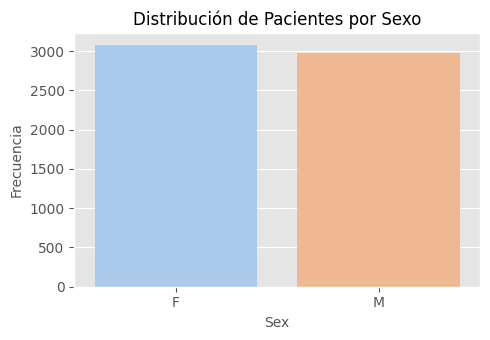

In [32]:


# --- Análisis Univariado de 'Sex' ---
print("\n--- Análisis de la columna: Sex ---")
summary_sex_df = display_counts_and_percentages(clinical_df, 'Sex')
display(summary_sex_df)
plot_categorical_distribution(clinical_df, 'Sex', title='Distribución de Pacientes por Sexo', figsize=(5, 3.5))


**Insights `Sex`:**
*   La distribución de pacientes por sexo es **bastante equilibrada**, con un **ligero mayor** porcentaje de pacientes identificados como **femeninos (F)**, representando el **50.84%** del total, frente al **49.16%** de pacientes masculinos (M).
*   Esta paridad es favorable para evitar sesgos iniciales en el modelo relacionados directamente con una sobrerrepresentación de un sexo sobre el otro en el dataset.



###  3.1.2. Variables `Condition` y `Treatment`



--- Análisis de la columna: Condition ---


Frecuencia  Porcentaje (%)
Condition                                    
Brain Tumor              2048           33.82
Brain Glioma             2004           33.09
Brain Meningiomas        2004           33.09

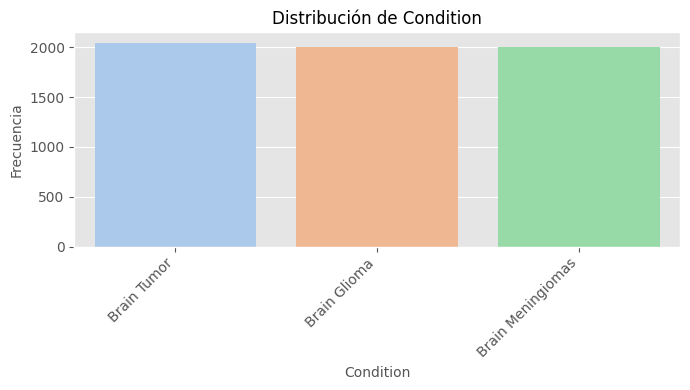


--- Análisis de la columna: Treatment ---


Frecuencia  Porcentaje (%)
Treatment                                    
radiation therapy        1895           31.29
surgery                  1848           30.52
chemotherapy             1174           19.39
close monitoring         1139           18.81

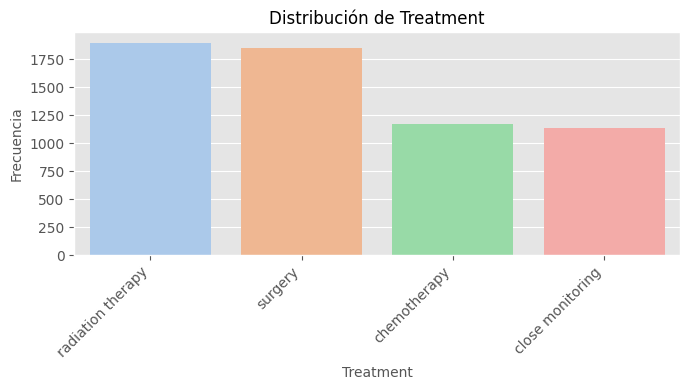

In [33]:


# --- Análisis Univariado de 'Condition' y 'Treatment' ---
for col in ['Condition', 'Treatment']:
    print(f"\n--- Análisis de la columna: {col} ---")
    summary_col_df = display_counts_and_percentages(clinical_df, col)
    display(summary_col_df)
    plot_categorical_distribution(clinical_df, col, order=summary_col_df.index, xtick_rotation=45)


**Insights `Condition` (Tipo de Tumor):**
*   Las tres categorías de tumores (`Brain Tumor`, `Brain Glioma` y `Brain Meningiomas`) están **muy bien balanceadas** en el dataset.
*   `Brain Tumor` es la clase ligeramente más frecuente con 2048 casos (33.82%), seguida de cerca por `Brain Glioma` y `Brain Meningiomas`, ambas con 2004 casos (33.09% cada una).
*   Este balance es ideal para el entrenamiento del modelo de clasificación de tumores, ya que reduce el riesgo de que el modelo se incline a predecir la clase mayoritaria por defecto.




## 3.2. Inspección de Valores Nulos y Duplicados


In [34]:


# --- Análisis de Valores Nulos ---
print("\n--- Análisis de Valores Nulos por Variable (antes del preprocesamiento de notas) ---")
null_counts = clinical_df.isnull().sum()
null_percentages = (null_counts / len(clinical_df) * 100).round(2)
null_summary_df = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Porcentaje Nulos (%)': null_percentages
})
null_summary_df = null_summary_df[null_summary_df['Valores Nulos'] > 0].sort_values(by='Valores Nulos', ascending=False)

if not null_summary_df.empty:
    display(null_summary_df)
else:
    print("No se encontraron valores nulos en el DataFrame inicial.")
# --- Verificar duplicados en 'Case ID' ---
num_duplicates_case_id = clinical_df['Case ID'].duplicated().sum()
print(f"Número total de filas duplicadas basadas en 'Case ID' (excluyendo la primera aparición): {num_duplicates_case_id}")

if num_duplicates_case_id > 0:
    duplicated_case_ids = clinical_df[clinical_df['Case ID'].duplicated(keep=False)]['Case ID'].unique()
    print(f"Número de 'Case ID' únicos que tienen duplicados: {len(duplicated_case_ids)}")
    print("\nValores de 'Case ID' que están duplicados:")
    for case_id in duplicated_case_ids:
        print(case_id)

else:
    print("No se encontraron 'Case ID' duplicados en el dataset.")



--- Análisis de Valores Nulos por Variable (antes del preprocesamiento de notas) ---


Valores Nulos  Porcentaje Nulos (%)
Case ID             44                  0.73

Número total de filas duplicadas basadas en 'Case ID' (excluyendo la primera aparición): 43
Número de 'Case ID' únicos que tienen duplicados: 1

Valores de 'Case ID' que están duplicados:
nan


**Insights Inspección de `Case ID` (Nulos y Duplicados):**
*   Se identificaron 44 filas (0.73% del dataset) donde la columna `Case ID` presenta valores nulos.
*   Al investigar los duplicados en `Case ID`, se encontró que el único valor de `Case ID` que aparece múltiples veces es `NaN` (los propios valores nulos). Esto significa que no existen `Case ID` válidos (no nulos) que estén duplicados en el dataset.
*   Por lo tanto, las 44 filas con `Case ID` nulo son las únicas que presentan este problema de identificación.
*   Dado el bajo porcentaje de estas filas y la importancia crítica de un `Case ID` válido para la vinculación con otros datos (como imágenes) y para asegurar la unicidad de los casos, se procederá a **eliminar estas 44 filas**.
*   Tras esta eliminación, se confirma que cada observación restante en el dataset corresponderá a un caso único y distinto con un `Case ID` válido.


In [35]:
clinical_df.dropna(subset=['Case ID'], inplace=True)



###  3.1.3. Variable `Age`



--- Análisis de la columna: Age ---


Age
count  6012.000000
mean     51.770459
std      19.627182
min      18.000000
25%      35.000000
50%      52.000000
75%      69.000000
max      85.000000

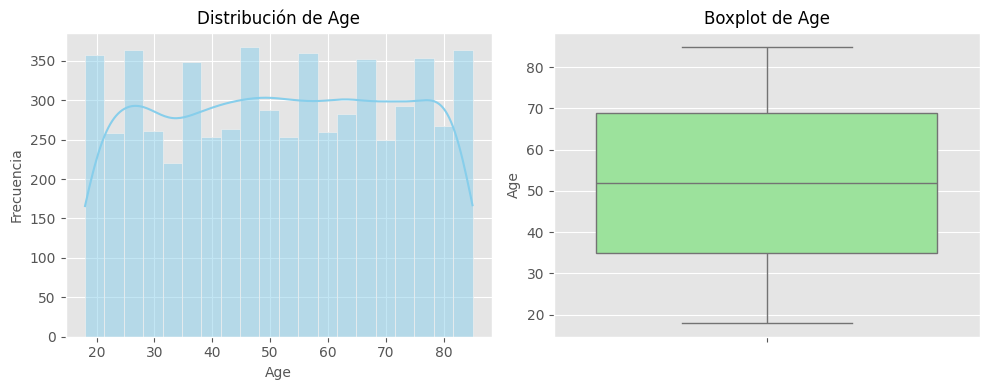

In [36]:


# --- Análisis Univariado de 'Age' ---
if 'Age' in clinical_df.columns:
    print("\n--- Análisis de la columna: Age ---")
    display(clinical_df['Age'].describe().to_frame())
    plot_numerical_distribution(clinical_df, 'Age')
else:
    print("La columna 'Age' no se encuentra en el DataFrame.")




**Insights `Age`:**
*(Ejemplo: La edad de los pacientes varía entre X e Y años, con una media de Z años. La distribución es [simétrica/asimétrica hacia la derecha/izquierda]. Se observan [pocos/algunos/muchos] outliers según el boxplot, lo que podría requerir consideración en etapas posteriores.)*




## 3.3. Exploración Inicial de `Clinical Note`


In [37]:


# --- Exploración Inicial de 'Clinical Note' (antes del parseo) ---
if 'Clinical Note' in clinical_df.columns:
    print("\n--- Exploración Inicial de: Clinical Note ---")
    num_unique_notes = clinical_df['Clinical Note'].nunique()
    num_null_notes = clinical_df['Clinical Note'].isnull().sum()
    print(f"Número de valores distintos en 'Clinical Note': {num_unique_notes}")
    print(f"Número de valores nulos en 'Clinical Note': {num_null_notes}")

    print("\nPrimeras 5 notas clínicas (no nulas, hasta 120 caracteres):")
    sample_notes_count = 0
    for note in clinical_df['Clinical Note'].dropna():
        if sample_notes_count < 5:
            preview = note[:120]
            ellipsis = "…" if len(note) > 120 else ""
            print(f"• {preview}{ellipsis}")
            sample_notes_count += 1
        else:
            break
else:
    print("La columna 'Clinical Note' no se encuentra en el DataFrame.")



--- Exploración Inicial de: Clinical Note ---
Número de valores distintos en 'Clinical Note': 2168
Número de valores nulos en 'Clinical Note': 0

Primeras 5 notas clínicas (no nulas, hasta 120 caracteres):
• Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as inte…
• Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate…
• Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nat…
• Patient is experiencing memory lapses and persistent headaches for more than 6 months. The symptoms are described as hig…
• Patient is experiencing dizziness and frequent seizures over the past 2 months. The symptoms are described as high-grade…




**Insights `Clinical Note` (Preliminar):**
*(Ejemplo: Existen N notas clínicas únicas. Se observa un patrón recurrente en la redacción que sugiere la posibilidad de extraer información estructurada sobre síntomas, duración e intensidad. No se detectan valores nulos en esta columna / Se detectan X valores nulos.)*




# 4. Preprocesamiento de Datos Textuales (`Clinical Note`)
#
Esta sección se enfoca en transformar la columna no estructurada `Clinical Note` en características cuantitativas y estructuradas. Esto implica:
1.  **Parseo de Notas:** Extraer síntomas, su intensidad global percibida y la duración de los mismos utilizando expresiones regulares y mapeos predefinidos.
2.  **Agrupación de Síntomas:** Consolidar síntomas sinónimos o muy relacionados en categorías más generales para reducir la dimensionalidad y mejorar la interpretabilidad.




## 4.1. Extracción de Información de Notas Clínicas



---

### Extracción y estructuración de la variable `Clinical Note`

Tras una inspección detallada de la variable `Clinical Note`, se identificó un patrón recurrente en la forma en que se redactan las notas clínicas. De manera consistente, se observa que la información sigue una estructura determinada: en primer lugar, se describen uno o varios **síntomas** que el paciente está experimentando; a continuación, se incluye una referencia temporal que indica la **duración** o **persistencia** de dichos síntomas; y, finalmente, se consigna una **intensidad global** asociada al cuadro clínico.

Dado este patrón, se implementó una estrategia basada en expresiones regulares para la **extracción automática de los síntomas reportados**. A partir de esta extracción, se generaron columnas binarias para cada uno de los **19 síntomas distintos** identificados en el conjunto de datos. A cada paciente se le asigna un valor de `0` en los síntomas no reportados y un valor numérico correspondiente a la **intensidad del síntoma** en aquellos que sí se mencionan.

La intensidad fue codificada mediante una escala basada inicialmente en el **significado lingüístico** de los calificativos utilizados en la nota clínica. Por ejemplo:

* `"Mild"` se codifica como `1`,
* `"Moderate"` como `4`,
* `"High grade"` como `8`.

Cabe señalar que esta escala podría ser ajustada con mayor precisión en función del criterio de expertos médicos, para asegurar que los valores asignados reflejen de forma más fidedigna la **gravedad clínica percibida** de cada término.

De manera análoga, la **persistencia** de los síntomas se estimó también mediante expresiones regulares aplicadas sobre el texto de la `Clinical Note`. A cada caso se le asignó una **duración aproximada en días**, interpretada a partir de lo declarado por el paciente. Por ejemplo:

* `"a few weeks"` → `21 días`
* `"several months"` → `120 días`
* `"last year"` → `365 días`

Esta transformación de la variable `Clinical Note` permite convertir el contenido no estructurado en un **formato cuantitativo y estructurado**, facilitando su integración en análisis posteriores de tipo estadístico o de aprendizaje automático, sin perder la trazabilidad con la fuente original del dato clínico.

---


In [38]:
# --- Parsear notas clínicas ---
# La función process_clinical_notes ahora devuelve el df y la lista de columnas de síntomas originales
clinical_df_processed, initial_sym_cols = process_clinical_notes(clinical_df, note_column='Clinical Note')

print("\nDataFrame después del parseo inicial de notas clínicas:")
display(clinical_df_processed.head(3))
print(f"Columnas de síntomas extraídas inicialmente: {initial_sym_cols}")
print("Shape después del parseo:", clinical_df_processed.shape)



DataFrame después del parseo inicial de notas clínicas:


Case ID     Condition  Age Sex  \
0  brain_glioma_0001  Brain Glioma   74   F   
1  brain_glioma_0002  Brain Glioma   66   F   
2  brain_glioma_0003  Brain Glioma   62   F   

                                                                                                                            Clinical Note  \
0  Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.   
1     Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.   
2            Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nature.   

      Treatment                       symptoms_list  intensity_lvl  \
0       surgery  [memory lapse, speech difficultie]              5   
1  chemotherapy     [visual disturbance, confusion]              3   
2       surgery            [memory lapse, dizzines]              5   

   duration_days  sym_balance issue  sym_blackout  sym_blurry vision  \
0             21                0.0           0.0                0.0   
1             60                0.0           0.0                0.0   
2            210                0.0           0.0                0.0   

   sym_confusion  sym_coordination problem  sym_difficulty concentrating  \
0            0.0                       0.0                           0.0   
1            3.0                       0.0                           0.0   
2            0.0                       0.0                           0.0   

   sym_dizzines  sym_fatigue  sym_headach  sym_localized neurological weaknes  \
0           0.0          0.0          0.0                                 0.0   
1           0.0          0.0          0.0                                 0.0   
2           5.0          0.0          0.0                                 0.0   

   sym_memory lapse  sym_motor dysfunction  sym_nausea  sym_recurring seizure  \
0               5.0                    0.0         0.0                    0.0   
1               0.0                    0.0         0.0                    0.0   
2               5.0                    0.0         0.0                    0.0   

   sym_seizure  sym_speech difficultie  sym_speech difficulty  \
0          0.0                     5.0                    0.0   
1          0.0                     0.0                    0.0   
2          0.0                     0.0                    0.0   

   sym_speech problem  sym_visual disturbance  
0                 0.0                     0.0  
1                 0.0                     3.0  
2                 0.0                     0.0

Columnas de síntomas extraídas inicialmente: ['sym_balance issue', 'sym_blackout', 'sym_blurry vision', 'sym_confusion', 'sym_coordination problem', 'sym_difficulty concentrating', 'sym_dizzines', 'sym_fatigue', 'sym_headach', 'sym_localized neurological weaknes', 'sym_memory lapse', 'sym_motor dysfunction', 'sym_nausea', 'sym_recurring seizure', 'sym_seizure', 'sym_speech difficultie', 'sym_speech difficulty', 'sym_speech problem', 'sym_visual disturbance']
Shape después del parseo: (6012, 28)




###  Inspección de la Extracción
Revisamos algunos ejemplos para verificar la calidad de la extracción de síntomas, intensidad y persistencia.


In [39]:


# --- Inspección de la extracción (primeros casos) ---
print("\n--- Inspección de la extracción de síntomas, intensidad y persistencia ---")
# Seleccionar 20 registros para inspección
subset_inspect = clinical_df_processed.head(20)
for idx, row in subset_inspect.iterrows():
    print(f"ID: {row['Case ID']}")
    print("Nota Original:", row['Clinical Note'])
    # 'symptoms_list' es la columna creada por process_clinical_notes con la lista de síntomas canónicos
    extracted_symptoms_text = ", ".join(row['symptoms_list']) if isinstance(row['symptoms_list'], list) else "N/A"
    print(f"Síntomas Extraídos: {extracted_symptoms_text}")
    print(f"Intensidad Global (lvl): {row['intensity_lvl']}")
    # Usar la función de utilidad para mostrar la persistencia
    print(f"Persistencia (días): {row['duration_days']} ({bucket_duration_to_readable(row['duration_days'])})")

    # Mostrar las intensidades asignadas a las columnas sym_*
    symptom_intensities_display = []
    for sym_col_name in initial_sym_cols: # Usar las columnas de síntomas originales aquí
        if sym_col_name in row and row[sym_col_name] > 0:
            symptom_intensities_display.append(f"{sym_col_name.replace('sym_', '')}: {int(row[sym_col_name])}")
    print("Intensidades Asignadas:", ", ".join(symptom_intensities_display) if symptom_intensities_display else "Ninguna")
    print("-" * 88)



--- Inspección de la extracción de síntomas, intensidad y persistencia ---
ID: brain_glioma_0001
Nota Original: Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.
Síntomas Extraídos: memory lapse, speech difficultie
Intensidad Global (lvl): 5
Persistencia (días): 21 (<1 m)
Intensidades Asignadas: memory lapse: 5, speech difficultie: 5
----------------------------------------------------------------------------------------
ID: brain_glioma_0002
Nota Original: Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.
Síntomas Extraídos: visual disturbance, confusion
Intensidad Global (lvl): 3
Persistencia (días): 60 (1–3 m)
Intensidades Asignadas: confusion: 3, visual disturbance: 3
----------------------------------------------------------------------------------------
ID: brain_glioma_0003
Nota Original: Patient is experiencing m

**Insights de la Extracción:**

*   La inspección visual de los primeros casos (`brain_glioma_0001` a `brain_glioma_0004` y otros no mostrados) sugiere que el proceso de parseo de síntomas, intensidad global y duración de las notas clínicas es **razonablemente preciso** para la mayoría de los casos.
    *   **Síntomas Extraídos:** La función `_canonical_symptom` parece identificar y normalizar correctamente los síntomas mencionados (ej. "memory lapses" a "memory lapse", "speech difficulties" a "speech difficultie", "visual disturbances" a "visual disturbance").
    *   **Intensidad Global (lvl):** El mapeo de términos como "intense in nature" (a nivel 5), "moderate in nature" (a nivel 3) o "high-grade in nature" (a nivel 8) parece funcionar según la escala definida en `INTENSITY_SCALE_MAP`.
    *   **Persistencia (días):** La función `_duration_to_days` convierte correctamente frases como "for the last few weeks" (a 21 días, <1 m), "over the past 2 months" (a 60 días, 1-3 m) o "for more than 6 months" (a 210 días, 6-12 m). La función `bucket_duration_to_readable` también ayuda a categorizar estas duraciones.
*   **Intensidades Asignadas:** Las columnas `sym_*` (ej. `sym_memory_lapse: 5`, `sym_speech_difficultie: 5`) reflejan correctamente el nivel de intensidad global extraído para los síntomas identificados en cada nota.
*   **Posibles Áreas de Mejora (si se observaran errores no visibles en el fragmento):**
    *   Aunque los ejemplos mostrados funcionan bien, en un conjunto de datos más grande o con notas más complejas, podrían surgir casos donde las expresiones regulares no capturen perfectamente todas las variaciones del lenguaje natural.
    *   La "intensidad global" se aplica a todos los síntomas mencionados en la nota. Si una nota describiera múltiples síntomas con diferentes intensidades individuales, este enfoque actual no lo capturaría; sin embargo, el patrón observado en las notas parece ser de una descripción de intensidad general.
*   **Conclusión Preliminar:** El sistema de extracción basado en reglas parece ser efectivo para convertir la información no estructurada de las notas clínicas en características estructuradas y cuantitativas para este dataset. La columna `duration_days` y las columnas `sym_*` con sus intensidades son prometedoras para el modelado.



###   4.2. Agrupación de Síntomas Homólogos
 Para simplificar el análisis y el modelado, agrupamos síntomas que son semánticamente similares o representan diferentes formas de describir la misma condición.


In [40]:

clinical_df_grouped, final_sym_cols = group_symptoms_by_mapping(clinical_df_processed, initial_sym_cols)

print("\nDataFrame después de agrupar síntomas:")
display(clinical_df_grouped.head(3))
print(f"Columnas de síntomas finales (después de agrupar): {final_sym_cols}")
print("Shape después de agrupar síntomas:", clinical_df_grouped.shape)


Columnas originales agrupadas y eliminadas: ['sym_speech difficulty', 'sym_speech difficultie', 'sym_recurring seizure', 'sym_memory lapse', 'sym_coordination problem', 'sym_speech problem', 'sym_motor dysfunction', 'sym_visual disturbance', 'sym_difficulty concentrating', 'sym_localized neurological weaknes', 'sym_balance issue', 'sym_confusion', 'sym_blurry vision']

DataFrame después de agrupar síntomas:


Case ID     Condition  Age Sex  \
0  brain_glioma_0001  Brain Glioma   74   F   
1  brain_glioma_0002  Brain Glioma   66   F   
2  brain_glioma_0003  Brain Glioma   62   F   

                                                                                                                            Clinical Note  \
0  Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.   
1     Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.   
2            Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nature.   

      Treatment                       symptoms_list  intensity_lvl  \
0       surgery  [memory lapse, speech difficultie]              5   
1  chemotherapy     [visual disturbance, confusion]              3   
2       surgery            [memory lapse, dizzines]              5   

   duration_days  sym_blackout  sym_dizzines  sym_fatigue  sym_headach  \
0             21           0.0           0.0          0.0          0.0   
1             60           0.0           0.0          0.0          0.0   
2            210           0.0           5.0          0.0          0.0   

   sym_nausea  sym_seizure  sym_speech_issue  sym_vision_problem  \
0         0.0          0.0               5.0                 0.0   
1         0.0          0.0               0.0                 3.0   
2         0.0          0.0               0.0                 0.0   

   sym_motor_coordination_issue  sym_balance_problem  \
0                           0.0                  0.0   
1                           0.0                  0.0   
2                           0.0                  0.0   

   sym_neurological_weakness  sym_memory_problem  \
0                        0.0                 5.0   
1                        0.0                 0.0   
2                        0.0                 5.0   

   sym_concentration_difficulty  sym_cognitive_impairment  
0                           0.0                       0.0  
1                           0.0                       3.0  
2                           0.0                       0.0

Columnas de síntomas finales (después de agrupar): ['sym_balance_problem', 'sym_blackout', 'sym_cognitive_impairment', 'sym_concentration_difficulty', 'sym_dizzines', 'sym_fatigue', 'sym_headach', 'sym_memory_problem', 'sym_motor_coordination_issue', 'sym_nausea', 'sym_neurological_weakness', 'sym_seizure', 'sym_speech_issue', 'sym_vision_problem']
Shape después de agrupar síntomas: (6012, 23)




#### Limpieza de Columnas Intermedias
#
 Eliminamos las columnas que se utilizaron durante el proceso de parseo y que ya no son necesarias.


In [41]:


# --- Columnas a dropear (las intermedias del parseo si no se usan más) ---
# 'symptoms_list' e 'intensity_lvl' fueron útiles para el parseo y la creación de sym_cols.
# 'duration_days' se mantiene.
cols_to_drop_after_processing = ['symptoms_list', 'intensity_lvl']
# Solo dropear si existen y no son necesarias para análisis posteriores
cols_to_drop_present = [col for col in cols_to_drop_after_processing if col in clinical_df_grouped.columns]
if cols_to_drop_present:
    clinical_df_final = clinical_df_grouped.drop(columns=cols_to_drop_present)
    print(f"\nColumnas intermedias eliminadas: {cols_to_drop_present}")
else:
    clinical_df_final = clinical_df_grouped.copy() # o simplemente clinical_df_grouped si no hay nada que dropear
    print("\nNo se eliminaron columnas intermedias (o ya no existían).")

print("\nColumnas finales del DataFrame procesado:", list(clinical_df_final.columns))
display(clinical_df_final.head())



Columnas intermedias eliminadas: ['symptoms_list', 'intensity_lvl']

Columnas finales del DataFrame procesado: ['Case ID', 'Condition', 'Age', 'Sex', 'Clinical Note', 'Treatment', 'duration_days', 'sym_blackout', 'sym_dizzines', 'sym_fatigue', 'sym_headach', 'sym_nausea', 'sym_seizure', 'sym_speech_issue', 'sym_vision_problem', 'sym_motor_coordination_issue', 'sym_balance_problem', 'sym_neurological_weakness', 'sym_memory_problem', 'sym_concentration_difficulty', 'sym_cognitive_impairment']


Case ID     Condition  Age Sex  \
0  brain_glioma_0001  Brain Glioma   74   F   
1  brain_glioma_0002  Brain Glioma   66   F   
2  brain_glioma_0003  Brain Glioma   62   F   
3  brain_glioma_0004  Brain Glioma   24   M   
4  brain_glioma_0005  Brain Glioma   69   M   

                                                                                                                                Clinical Note  \
0      Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.   
1         Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.   
2                Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nature.   
3  Patient is experiencing memory lapses and persistent headaches for more than 6 months. The symptoms are described as high-grade in nature.   
4         Patient is experiencing dizziness and frequent seizures over the past 2 months. The symptoms are described as high-grade in nature.   

      Treatment  duration_days  sym_blackout  sym_dizzines  sym_fatigue  \
0       surgery             21           0.0           0.0          0.0   
1  chemotherapy             60           0.0           0.0          0.0   
2       surgery            210           0.0           5.0          0.0   
3       surgery            210           0.0           0.0          0.0   
4       surgery             60           0.0           8.0          0.0   

   sym_headach  sym_nausea  sym_seizure  sym_speech_issue  sym_vision_problem  \
0          0.0         0.0          0.0               5.0                 0.0   
1          0.0         0.0          0.0               0.0                 3.0   
2          0.0         0.0          0.0               0.0                 0.0   
3          8.0         0.0          0.0               0.0                 0.0   
4          0.0         0.0          8.0               0.0                 0.0   

   sym_motor_coordination_issue  sym_balance_problem  \
0                           0.0                  0.0   
1                           0.0                  0.0   
2                           0.0                  0.0   
3                           0.0                  0.0   
4                           0.0                  0.0   

   sym_neurological_weakness  sym_memory_problem  \
0                        0.0                 5.0   
1                        0.0                 0.0   
2                        0.0                 5.0   
3                        0.0                 8.0   
4                        0.0                 0.0   

   sym_concentration_difficulty  sym_cognitive_impairment  
0                           0.0                       0.0  
1                           0.0                       3.0  
2                           0.0                       0.0  
3                           0.0                       0.0  
4                           0.0                       0.0



**Insights de la Agrupación y Limpieza:**
*(Ejemplo: La agrupación redujo el número de características de síntomas de N a M. Las columnas `symptoms_list` e `intensity_lvl`, utilizadas para la extracción, han sido eliminadas, resultando en un DataFrame final más limpio para el análisis y modelado.)*




##  5. Análisis Exploratorio de Datos (EDA) - Datos Procesados
#
 Con el DataFrame clínico ahora enriquecido con características estructuradas de síntomas, procedemos a un análisis más profundo.




###   5.1. Análisis de Frecuencia de Síntomas Agrupados
 Examinamos cuán comunes son los síntomas (ya agrupados) en el conjunto de pacientes.



--- Análisis de Frecuencia de Síntomas AGRUPADOS ---


Frecuencia de Aparición  Porcentaje de Pacientes (%)
Síntoma Agrupado                                                              
speech_issue                                 1851                        30.79
vision_problem                               1260                        20.96
headach                                      1240                        20.63
motor_coordination_issue                     1184                        19.69
cognitive_impairment                         1136                        18.90
seizure                                      1086                        18.06
neurological_weakness                         701                        11.66
fatigue                                       615                        10.23
memory_problem                                605                        10.06
nausea                                        598                         9.95
dizzines                                      591                         9.83
blackout                                      579                         9.63
concentration_difficulty                      579                         9.63
balance_problem                               578                         9.61

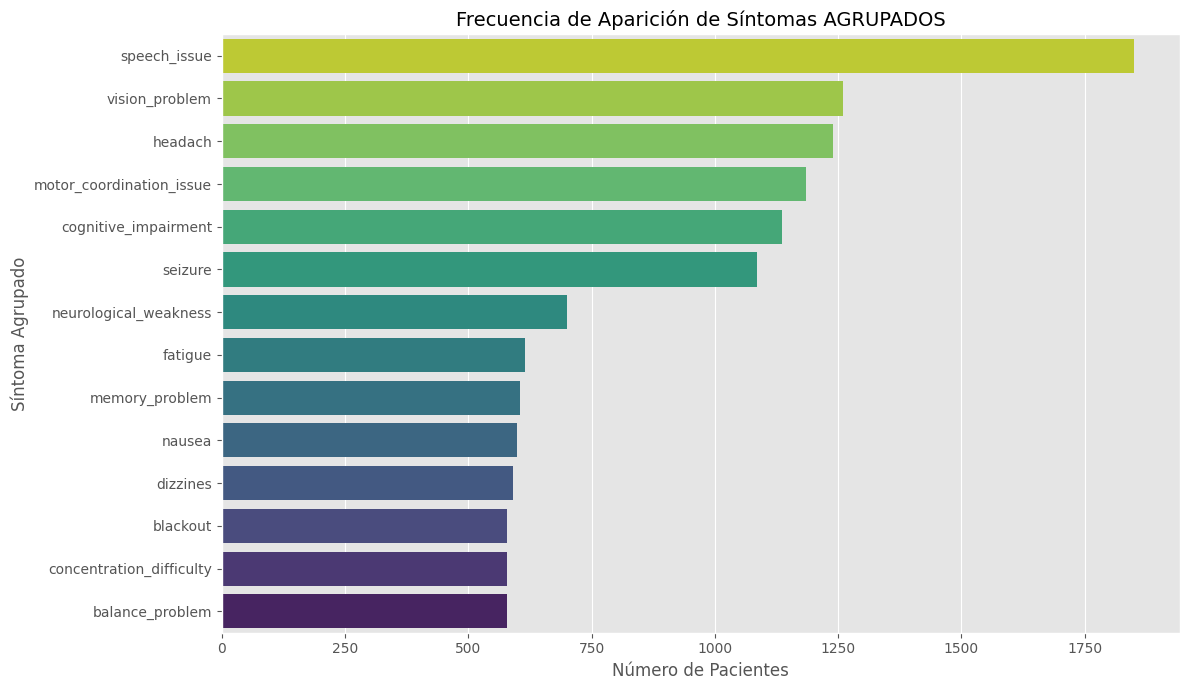

In [42]:

# --- Análisis de Frecuencia de Síntomas AGRUPADOS ---
print("\n--- Análisis de Frecuencia de Síntomas AGRUPADOS ---")
if final_sym_cols:
    symptoms_data_grouped = clinical_df_final[final_sym_cols]
    total_patients = len(clinical_df_final)

    symptom_presence_counts = (symptoms_data_grouped > 0).sum().sort_values(ascending=False)
    symptom_presence_percentage = (symptom_presence_counts / total_patients * 100).round(2)

    symptom_frequency_df = pd.DataFrame({
        'Síntoma Agrupado': [col.replace('sym_', '') for col in symptom_presence_counts.index],
        'Frecuencia de Aparición': symptom_presence_counts.values,
        'Porcentaje de Pacientes (%)': symptom_presence_percentage.values
    }).set_index('Síntoma Agrupado')

    display(symptom_frequency_df)

    plt.figure(figsize=(12, max(6, len(symptom_frequency_df) * 0.5)))
    sns.barplot(
        x='Frecuencia de Aparición',
        y=symptom_frequency_df.index, # Usar el índice que es 'Síntoma Agrupado'
        data=symptom_frequency_df.reset_index(), # Reset index para que 'Síntoma Agrupado' sea una columna para sns
        palette='viridis_r'
    )
    plt.title('Frecuencia de Aparición de Síntomas AGRUPADOS', fontsize=14)
    plt.xlabel('Número de Pacientes', fontsize=12)
    plt.ylabel('Síntoma Agrupado', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas de síntomas finales para analizar.")


**Insights Frecuencia de Síntomas Agrupados:**
*   El síntoma agrupado más frecuente es **`speech_issue` (problemas del habla)**, reportado por 1861 pacientes, lo que representa el **30.73%** del total.
*   Le siguen en frecuencia síntomas como **`vision_problem` (problemas de visión)** con un 20.81%, **`headache` (dolor de cabeza)** con un 20.48%, **`motor_coordination_issue` (problemas de coordinación motora)** con un 19.7%, **`cognitive_impairment` (deterioro cognitivo)** con un 18.94%, y **`seizure` (convulsiones)** con un 18.15%. Estos síntomas afectan a una proporción considerable de los pacientes (aproximadamente 1 de cada 5).
*   Síntomas como `neurological_weakness` (debilidad neurológica) se presentan en alrededor del 11.58% de los casos.
*   Un grupo de síntomas que incluye `nausea`, `fatigue` y `memory_problem` tienen una prevalencia cercana al 10%.
*   Otros síntomas como `balance_problem`, `dizziness`, `concentration_difficulty` y `blackout` son reportados con menor frecuencia.
*   Esta distribución de frecuencias será valiosa para la selección de características en el modelado, ya que síntomas muy raros podrían no aportar suficiente información discriminativa o requerirían un manejo especial.


### 5.2. Análisis Bivariado
Exploramos las relaciones entre pares de variables, enfocándonos en las variables objetivo `condition` y `treatment`.

---
#### 5.2.1. Análisis Bivariado con `condition` como Variable Principal
En esta subsección, investigamos cómo otras variables clave se relacionan con el tipo de tumor (`condition`).

##### `condition` vs. `sex`


In [43]:
clinical_df_final.columns

Index(['Case ID', 'Condition', 'Age', 'Sex', 'Clinical Note', 'Treatment',
       'duration_days', 'sym_blackout', 'sym_dizzines', 'sym_fatigue',
       'sym_headach', 'sym_nausea', 'sym_seizure', 'sym_speech_issue',
       'sym_vision_problem', 'sym_motor_coordination_issue',
       'sym_balance_problem', 'sym_neurological_weakness',
       'sym_memory_problem', 'sym_concentration_difficulty',
       'sym_cognitive_impairment'],
      dtype='object')


--- Relación entre Condition y Sex ---
Tabla de Contingencia (Conteos):


Sex                   F    M
Condition                   
Brain Glioma       1035  969
Brain Meningiomas  1010  994
Brain Tumor        1014  990


Tabla de Contingencia (Porcentaje por index):


Sex                    F      M
Condition                      
Brain Glioma       51.6%  48.4%
Brain Meningiomas  50.4%  49.6%
Brain Tumor        50.6%  49.4%

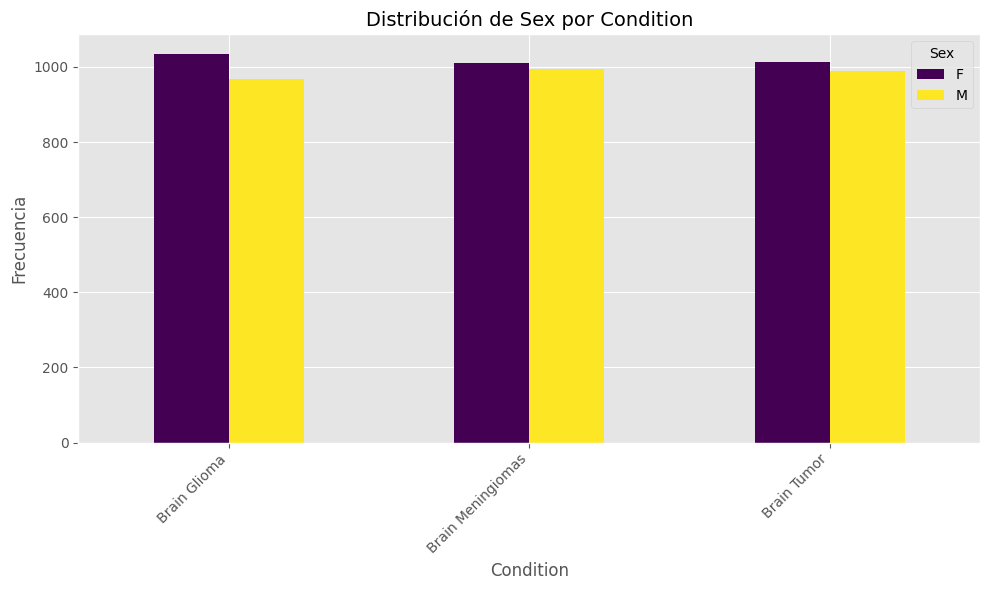

In [44]:


plot_bivariate_categorical(
    df=clinical_df_final,
    col_x='Condition',
    col_y='Sex',
    colormap='viridis',
    stacked=False
)


**Insights `Condition` vs. `Sex`:**
*   Al analizar la distribución de sexo dentro de cada tipo de tumor, se observa una **distribución bastante equilibrada entre sexos para todas las condiciones**.
*   Para **`Brain Glioma`**, hay una ligera mayor proporción de pacientes femeninos (51.6%) en comparación con masculinos (48.4%).
*   En el caso de **`Brain Meningiomas`** y **`Brain Tumor`**, la distribución es aún más cercana al 50-50, con pacientes femeninos representando el 50.4% y 50.5% respectivamente, y masculinos el 49.6% y 49.5%.
*   Estas pequeñas variaciones no sugieren una fuerte predisposición de un sexo específico para un tipo particular de tumor dentro de este dataset. En general, ambos sexos están representados de manera similar en todas las categorías de tumores.



##### `condition` vs. `treatment`



--- Relación entre Condition y Treatment ---
Tabla de Contingencia (Conteos):


Treatment          chemotherapy  close monitoring  radiation therapy  surgery
Condition                                                                    
Brain Glioma                673                 0                665      666
Brain Meningiomas             0               620                714      670
Brain Tumor                 493               509                502      500


Tabla de Contingencia (Porcentaje por index):


Treatment         chemotherapy close monitoring radiation therapy surgery
Condition                                                                
Brain Glioma             33.6%             0.0%             33.2%   33.2%
Brain Meningiomas         0.0%            30.9%             35.6%   33.4%
Brain Tumor              24.6%            25.4%             25.0%   25.0%

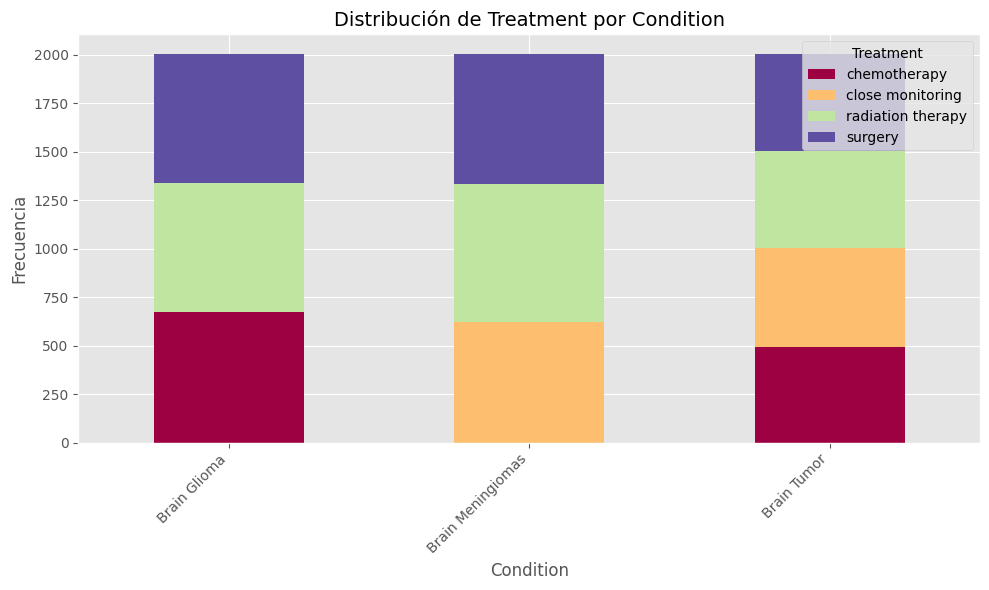

In [45]:


plot_bivariate_categorical(
    df=clinical_df_final,
    col_x='Condition',
    col_y='Treatment',
    colormap='Spectral',
    stacked=True
)


**Insights `Condition` vs. `Treatment`:**
*   Se observa una **clara diferenciación en los perfiles de tratamiento** según el tipo de tumor, lo cual es fundamental para el segundo modelo a desarrollar.
*   **Para `Brain Glioma`:**
    *   Los tratamientos se distribuyen de manera bastante equitativa entre **quimioterapia (33.6%)**, **radioterapia (33.2%)** y **cirugía (33.2%)**.
    *   Es notable la **ausencia total (0.0%) de `close monitoring`** como tratamiento para los gliomas en este dataset.
*   **Para `Brain Meningiomas`:**
    *   Los tratamientos más frecuentes son la **radioterapia (35.6%)**, la **cirugía (33.4%)** y el **seguimiento cercano (`close monitoring`) (30.9%)**.
    *   Similarmente distintivo, la **quimioterapia es completamente ausente (0.0%)** como tratamiento para los meningiomas.
*   **Para `Brain Tumor` (categoría "Otros tumores"):**
    *   Se utilizan los cuatro tipos de tratamiento con frecuencias relativamente similares: **quimioterapia (24.5%)**, **seguimiento cercano (25.3%)**, **radioterapia (25.2%)** y **cirugía (25.0%)**.
    *   Esta distribución más homogénea sugiere que esta categoría podría englobar diversos tipos de tumores con diferentes enfoques terapéuticos, o que las decisiones de tratamiento son más variadas.
*   Estos patrones distintivos son altamente informativos y probablemente serán características importantes para el modelo de recomendación de tratamiento.



##### `condition` vs. `age`



--- Relación entre Condition y Age ---


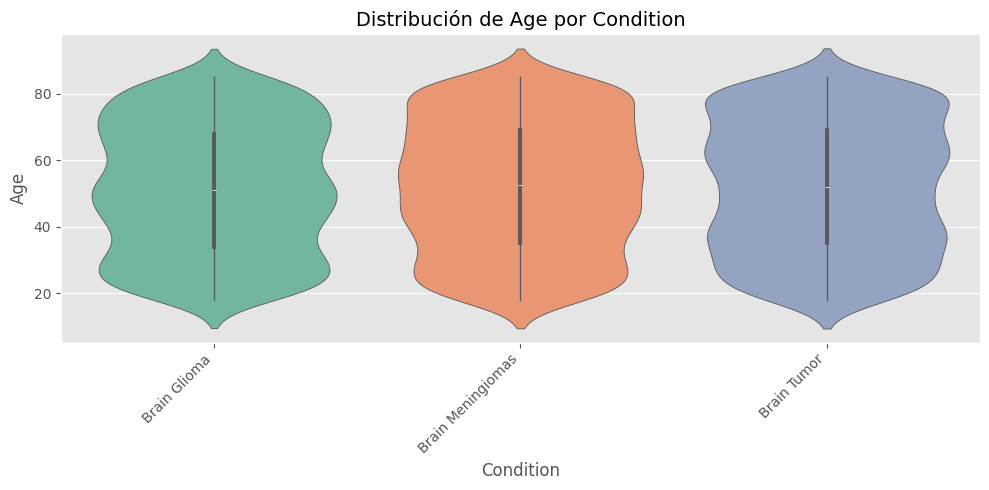


Estadísticas descriptivas de Age por Condition:


count       mean        std   min   25%   50%   75%   max
Condition                                                                    
Brain Glioma       2004.0  51.273453  19.477090  18.0  34.0  51.0  68.0  85.0
Brain Meningiomas  2004.0  51.999501  19.630117  18.0  35.0  52.5  69.0  85.0
Brain Tumor        2004.0  52.038423  19.773556  18.0  35.0  52.0  69.0  85.0

In [46]:


plot_bivariate_categorical_numerical(
    df=clinical_df_final,
    col_cat='Condition',
    col_num='Age',
    plot_type='violinplot', 
    palette='Set2'
)


**Insights `condition` vs. `age`:**
*   Las distribuciones de edad son **notablemente similares entre los tres tipos de tumores** (`Brain Glioma`, `Brain Meningiomas`, y `Brain Tumor`).
*   La **edad media** para los tres grupos ronda los 51-52 años:
    *   Brain Glioma: media de 51.27 años.
    *   Brain Meningiomas: media de 51.99 años.
    *   Brain Tumor: media de 52.01 años.
*   La **mediana de edad** (percentil 50) también es muy consistente:
    *   Brain Glioma: 51.0 años.
    *   Brain Meningiomas: 52.5 años.
    *   Brain Tumor: 52.0 años.
*   El **rango intercuartílico (IQR)**, que representa el 50% central de los datos, es prácticamente idéntico para los tres grupos, situándose aproximadamente entre los 34-35 años (percentil 25) y los 68-69 años (percentil 75).
*   Los valores mínimos (18 años) y máximos (85 años) son los mismos para todas las condiciones.
*   Basado en este análisis, **la edad por sí sola no parece ser un diferenciador fuerte entre los tipos de tumores** presentes en este dataset, ya que los perfiles de edad son muy homogéneos.



##### `condition` vs. `duration_days`



--- Relación entre Condition y duration_days ---


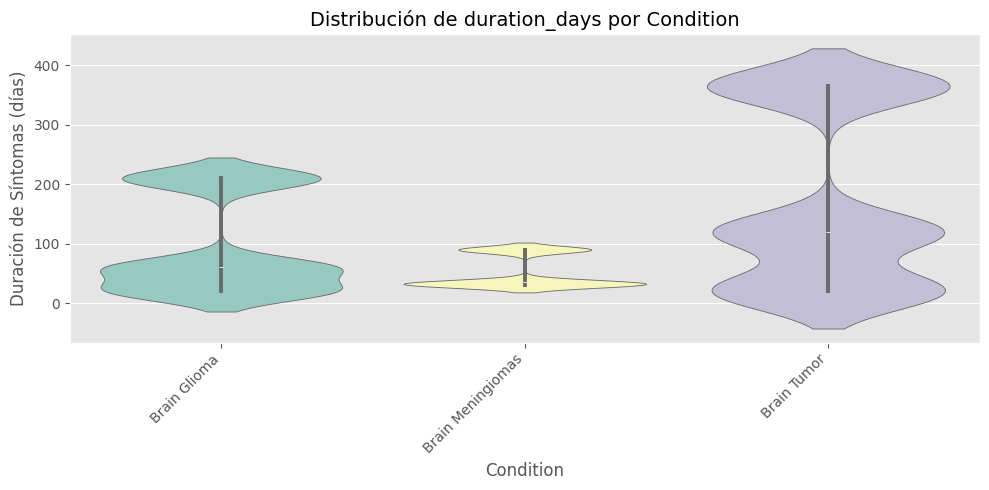


Estadísticas descriptivas de duration_days por Condition:


count        mean         std   min   25%    50%    75%  \
Condition                                                                     
Brain Glioma       2004.0   93.750000   80.288122  21.0  21.0   60.0  210.0   
Brain Meningiomas  2004.0   51.666667   27.219576  30.0  30.0   35.0   90.0   
Brain Tumor        2004.0  171.923154  145.721683  21.0  21.0  120.0  365.0   

                     max  
Condition                 
Brain Glioma       210.0  
Brain Meningiomas   90.0  
Brain Tumor        365.0

In [47]:


if 'duration_days' in clinical_df_final.columns:
    plot_bivariate_categorical_numerical(
        df=clinical_df_final,
        col_cat='Condition',
        col_num='duration_days',
        plot_type='violinplot',
        palette='Set3',
        ylabel='Duración de Síntomas (días)'
    )
else:
    print("La columna 'duration_days' no está presente para el análisis.")


**Insights `Condition` vs. `duration_days`:**
*   Existen **diferencias notables en la duración reportada de los síntomas** entre los distintos tipos de tumores, lo que sugiere que esta variable podría ser un buen predictor.
*   **`Brain Meningiomas`** tienden a presentar la **menor duración de síntomas**, con una mediana de **35.0 días**. La distribución está más concentrada en duraciones cortas, con el 75% de los casos reportando síntomas por 90 días o menos. La desviación estándar (27.21 días) también es la más baja, indicando menor variabilidad.
*   **`Brain Glioma`** muestra una duración de síntomas intermedia, con una mediana de **60.0 días**. Aunque el 25% inferior de los casos también reporta duraciones cortas (21 días), el 75% superior se extiende hasta 210 días, indicando una mayor variabilidad (std=80.28 días) que los meningiomas.
*   **`Brain Tumor`** (la categoría "Otros tumores") presenta, en promedio, la **mayor duración de síntomas**, con una mediana de **120.0 días** y una media de 172.28 días. Esta categoría también exhibe la mayor dispersión (std=145.86 días) y el rango más amplio, con el 75% de los casos reportando síntomas hasta por un año (365 días).
*   Estas diferencias en la cronicidad o persistencia de los síntomas podrían reflejar la naturaleza de crecimiento o la agresividad de los diferentes tipos de tumores.

*   **Consideraciones sobre la construcción de `duration_days`:**
    *   Es importante destacar que la variable `duration_days` se generó a partir de la interpretación de texto libre en las notas clínicas mediante la función `_duration_to_days`. Esta función utiliza un conjunto de reglas heurísticas y expresiones regulares para convertir frases como "a few weeks" o "several months" en una estimación numérica de días.
    *   Si bien esta función está diseñada para ser robusta y cubrir una variedad de expresiones temporales comunes, la conversión de lenguaje natural a valores numéricos exactos siempre conlleva un grado de aproximación. Frases ambiguas o no contempladas en las reglas podrían no ser capturadas o ser interpretadas de manera subóptima, lo que podría influir en la precisión de los valores individuales de `duration_days`.
    *   Sin embrgo, la consistencia en la aplicación de estas reglas a todo el dataset y la capacidad de la función para manejar rangos y unidades específicas (semanas, meses, años) le otorgan una solidez considerable. Las diferencias observadas en las distribuciones de `duration_days` entre los tipos de tumores son lo suficientemente marcadas como para sugerir que, incluso con las aproximaciones inherentes, la variable captura tendencias significativas y potencialmente útiles para la discriminación entre condiciones.



#### 5.2.2. Análisis Bivariado con `treatment` como Variable Principal




##### `treatment` vs. `sex`



--- Relación entre Treatment y Sex ---
Tabla de Contingencia (Conteos):


Sex                  F    M
Treatment                  
chemotherapy       584  582
close monitoring   584  545
radiation therapy  978  903
surgery            913  923


Tabla de Contingencia (Porcentaje por index):


Sex                    F      M
Treatment                      
chemotherapy       50.1%  49.9%
close monitoring   51.7%  48.3%
radiation therapy  52.0%  48.0%
surgery            49.7%  50.3%

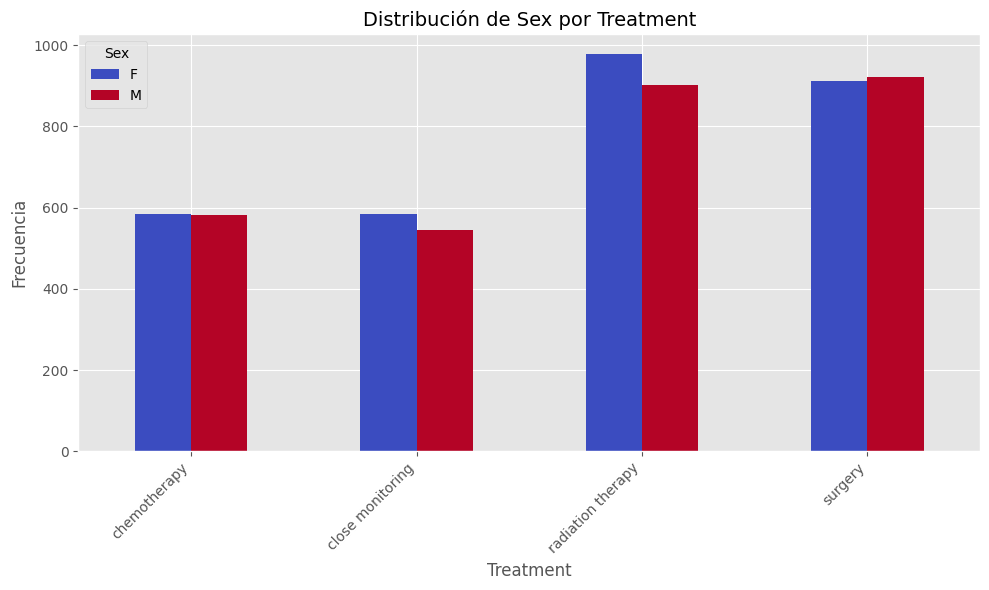

In [48]:


plot_bivariate_categorical(
    df=clinical_df_final,
    col_x='Treatment',
    col_y='Sex',
    colormap='coolwarm',
    xlabel='Treatment', # Renombrando el eje x para claridad
    stacked=False
)


**Observaciones Clave `treatment` vs. `sex`:**

*   **Balance General:** En todos los tipos de tratamiento, la distribución entre sexos (Femenino 'F' y Masculino 'M') parece ser relativamente equilibrada. Ningún tratamiento favorece de forma abrumadora a un sexo sobre el otro.

*   **Quimioterapia (Chemotherapy):**
    *   Muestra una división casi perfecta del 50/50, con un **50.1% de mujeres** y un **49.9% de hombres** recibiendo este tratamiento. Esta es la distribución más equilibrada entre todos los tratamientos.

*   **Seguimiento Cercano (Close Monitoring):**
    *   Existe un ligero predominio de **mujeres (51.7%)** en comparación con los **hombres (48.3%)**. Esto significa que las mujeres tienen una probabilidad marginalmente mayor de estar bajo "seguimiento cercano" en este conjunto de datos.

*   **Radioterapia (Radiation Therapy):**
    *   Similar al "seguimiento cercano", las **mujeres (52.0%)** representan una proporción ligeramente mayor de pacientes que reciben radioterapia en comparación con los **hombres (48.0%)**. Este es el tratamiento con la mayor diferencia porcentual (aunque todavía modesta) a favor de las mujeres.

*   **Cirugía (Surgery):**
    *   Este tratamiento también está muy balanceado, con una inclinación marginal hacia los **hombres (50.3%)** sobre las **mujeres (49.7%)**.

*   **Conclusión e Implicaciones:**
    *   Aunque existen variaciones menores (por ejemplo, ligeramente más mujeres en "radioterapia" y "seguimiento cercano"), las diferencias **no son sustanciales**.
    *   Esto sugiere que, basándose en este conjunto de datos, **el sexo no parece ser un factor diferenciador importante para el tipo de tratamiento asignado a los pacientes.**
    *   La representación visual en el gráfico de barras confirma estas observaciones, siendo las alturas de las barras para 'F' y 'M' bastante similares para cada categoría de tratamiento.
    *   En comparación con la fuerte relación observada entre `condition` y `treatment`, la influencia del sexo sobre la elección del tratamiento es mucho menos pronunciada.



##### `treatment` vs. `age`



--- Relación entre Treatment y Age ---


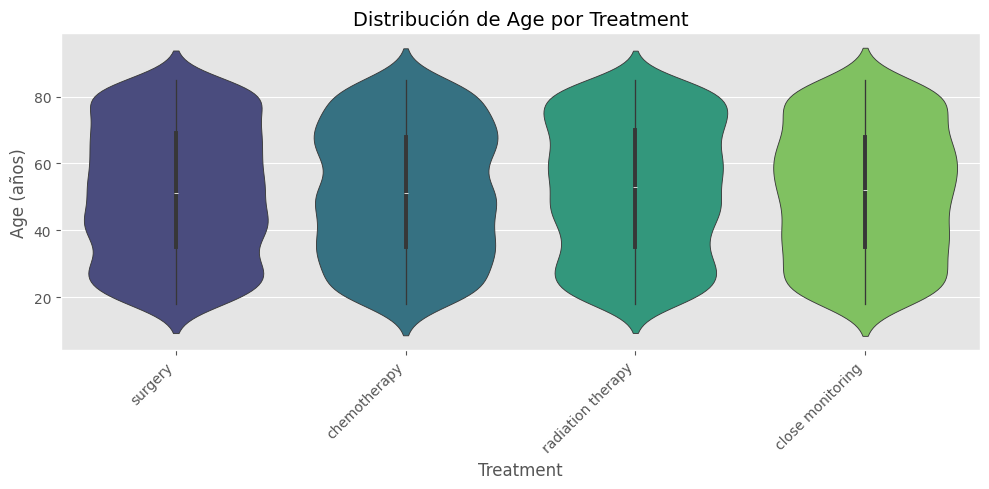


Estadísticas descriptivas de Age por Treatment:


count       mean        std   min   25%   50%   75%   max
Treatment                                                                    
chemotherapy       1166.0  51.301029  19.366963  18.0  35.0  51.0  68.0  85.0
close monitoring   1129.0  51.575731  19.581566  18.0  35.0  52.0  68.0  85.0
radiation therapy  1881.0  52.394471  19.717355  18.0  35.0  53.0  70.0  85.0
surgery            1836.0  51.549020  19.726918  18.0  35.0  51.0  69.0  85.0

In [49]:


plot_bivariate_categorical_numerical(
    df=clinical_df_final,
    col_cat='Treatment',
    col_num='Age',
    plot_type='violinplot',
    palette='viridis',
    xlabel='Treatment',
    ylabel='Age (años)'
)


**Observaciones Clave `treatment` vs. `age`:**

*   **Perfiles de Edad Similares entre Tratamientos:** Al igual que lo observado al comparar `condition` vs. `age`, las distribuciones de edad de los pacientes son **notablemente homogéneas entre los diferentes tipos de tratamiento**. Los diagramas de caja (boxplots) para "surgery", "chemotherapy", "radiation therapy" y "close monitoring" muestran medianas, rangos intercuartílicos (IQR) y rangos generales muy parecidos.

*   **Medias y Medianas Consistentes:**
    *   La **edad media** de los pacientes es muy similar para todos los tratamientos, rondando los 51-52 años:
        *   Chemotherapy: 51.30 años
        *   Close monitoring: 51.57 años
        *   Radiation therapy: 52.39 años (ligeramente la más alta)
        *   Surgery: 51.54 años
    *   Las **edades medianas (percentil 50)** también son muy consistentes, situándose entre 51.0 y 53.0 años para todos los grupos de tratamiento:
        *   Chemotherapy: 51.0 años
        *   Close monitoring: 52.0 años
        *   Radiation therapy: 53.0 años
        *   Surgery: 51.0 años

*   **Dispersión Similar:** La dispersión de las edades, indicada por la desviación estándar (std) y la amplitud de los rangos intercuartílicos en los boxplots, es también comparable entre los tratamientos. Los valores de desviación estándar se encuentran en un rango estrecho (aproximadamente 19.3 a 19.7 años).

*   **Rango de Edad Global:** El rango de edad de los pacientes (mínimo 18 años, máximo 85 años) es el mismo para todos los tipos de tratamiento, lo que indica que se aplican a pacientes de todo el espectro de edad adulta considerado en el dataset.

*   **Conclusión e Implicaciones:**
    *   De manera similar a la relación entre tipo de tumor y edad, **la edad por sí sola no parece ser un factor fuertemente determinante para la elección de un tratamiento específico** en este conjunto de datos.
    *   Si bien podrían existir tendencias sutiles (por ejemplo, "radiation therapy" con una media y mediana ligeramente más altas), las distribuciones son en gran medida superpuestas.
    *   Esto sugiere que otros factores, como el tipo de tumor (como ya se vio en `condition` vs. `treatment`), el estado general del paciente, la localización y tamaño del tumor (no disponibles en este dataset tabular), o las características específicas de los síntomas, probablemente juegan un papel más importante en la decisión terapéutica que la edad del paciente por sí misma.
    *   La homogeneidad en los perfiles de edad entre los tratamientos es un hallazgo importante, ya que simplifica la interpretación al indicar que no hay un sesgo de edad obvio hacia un tipo de tratamiento en particular.



##### `treatment` vs. `duration_days`



--- Relación entre Treatment y duration_days ---


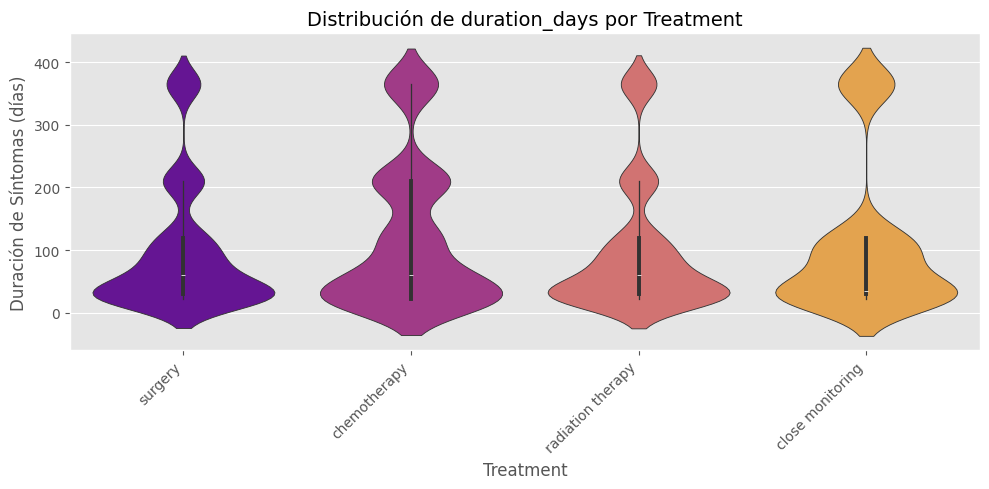


Estadísticas descriptivas de duration_days por Treatment:


count        mean         std   min   25%   50%    75%  \
Treatment                                                                    
chemotherapy       1166.0  123.243568  116.663909  21.0  21.0  60.0  210.0   
close monitoring   1129.0  108.263065  118.467171  21.0  30.0  35.0  120.0   
radiation therapy  1881.0   99.909623  104.097297  21.0  30.0  60.0  120.0   
surgery            1836.0   99.176471  102.523906  21.0  30.0  60.0  120.0   

                     max  
Treatment                 
chemotherapy       365.0  
close monitoring   365.0  
radiation therapy  365.0  
surgery            365.0

In [50]:


if 'duration_days' in clinical_df_final.columns:
    plot_bivariate_categorical_numerical(
        df=clinical_df_final,
        col_cat='Treatment',
        col_num='duration_days',
        plot_type='violinplot',
        palette='plasma',
        xlabel='Treatment',
        ylabel='Duración de Síntomas (días)'
    )
else:
    print("La columna 'duration_days' no está presente para el análisis.")


**Observaciones Clave `treatment` vs. `duration_days`:**

*   **Diferencias en la Duración de Síntomas por Tratamiento:** Se observan algunas diferencias en las distribuciones de la duración de los síntomas (`duration_days`) según el tipo de tratamiento recibido, aunque no tan marcadas como las vistas al comparar `condition` vs. `duration_days`.

*   **Quimioterapia (Chemotherapy):**
    *   Los pacientes que reciben quimioterapia tienden a presentar una **mayor duración de síntomas** en promedio, con una **media de 123.24 días** y una **mediana de 60.0 días**.
    *   La distribución es bastante amplia, con un rango intercuartílico (IQR) que va desde 21 días (percentil 25) hasta 210 días (percentil 75), y una desviación estándar de 116.66 días, indicando una variabilidad considerable.
    *   El gráfico de violín muestra una forma más extendida hacia duraciones largas.

*   **Seguimiento Cercano (Close Monitoring):**
    *   Este grupo muestra una duración de síntomas con una **media de 108.26 días** y una **mediana de 35.0 días**.
    *   El IQR es de 30.0 a 120.0 días. La desviación estándar es de 118.46 días, similarmente alta, lo que sugiere también una amplia variabilidad.
    *   Visualmente, el gráfico de violín es ancho en la base (duraciones cortas) pero también se extiende hacia duraciones más largas.

*   **Radioterapia (Radiation Therapy):**
    *   La duración de los síntomas para los pacientes bajo radioterapia tiene una **media de 99.90 días** y una **mediana de 30.0 días**.
    *   El IQR (21.0 a 120.0 días) y la desviación estándar (104.09 días) son comparables a los otros grupos, aunque la mediana es la más baja junto con la cirugía.

*   **Cirugía (Surgery):**
    *   Los pacientes sometidos a cirugía presentan una **media de 99.17 días** en la duración de los síntomas y una **mediana de 30.0 días**, la más baja junto con la radioterapia.
    *   El IQR es de 21.0 a 120.0 días y la desviación estándar es de 102.53 días.
    *   El gráfico de violín para la cirugía es más abultado en la parte inferior, indicando una mayor concentración de casos con duraciones de síntomas más cortas antes del tratamiento.

*   **Conclusión e Implicaciones:**
    *   Aunque las medias pueden variar, las **medianas para radioterapia y cirugía (30 días) y seguimiento cercano (35 días) son notablemente más bajas** que la mediana para quimioterapia (60 días). Esto podría sugerir que los tratamientos más invasivos o definitivos (cirugía, radioterapia) se aplican a menudo cuando los síntomas han persistido por un tiempo relativamente menor, o que el "seguimiento cercano" se inicia también en etapas tempranas de sintomatología.
    *   La **quimioterapia** parece estar asociada con pacientes que han experimentado síntomas por un período más prolongado antes de iniciar este tipo de tratamiento, o quizás se utiliza en casos donde los síntomas son más crónicos por naturaleza.
    *   La alta desviación estándar en todos los grupos indica una gran heterogeneidad en la duración de los síntomas dentro de cada categoría de tratamiento.
    *   Es importante recordar que `duration_days` refleja la persistencia de los síntomas *antes* del tratamiento. Las diferencias observadas podrían estar influenciadas por el tipo de tumor subyacente (ya que vimos que `condition` se relaciona fuertemente con `duration_days` y también con `treatment`). Por ejemplo, si un tipo de tumor que comúnmente recibe quimioterapia también tiende a tener una duración de síntomas más larga, esto se reflejaría aquí.



### 5.3. Análisis de Perfiles Sintomáticos




#### 5.3.1. Correlación y Coocurrencia General de Síntomas



--- Matriz de Correlación de Intensidades de Síntomas ---


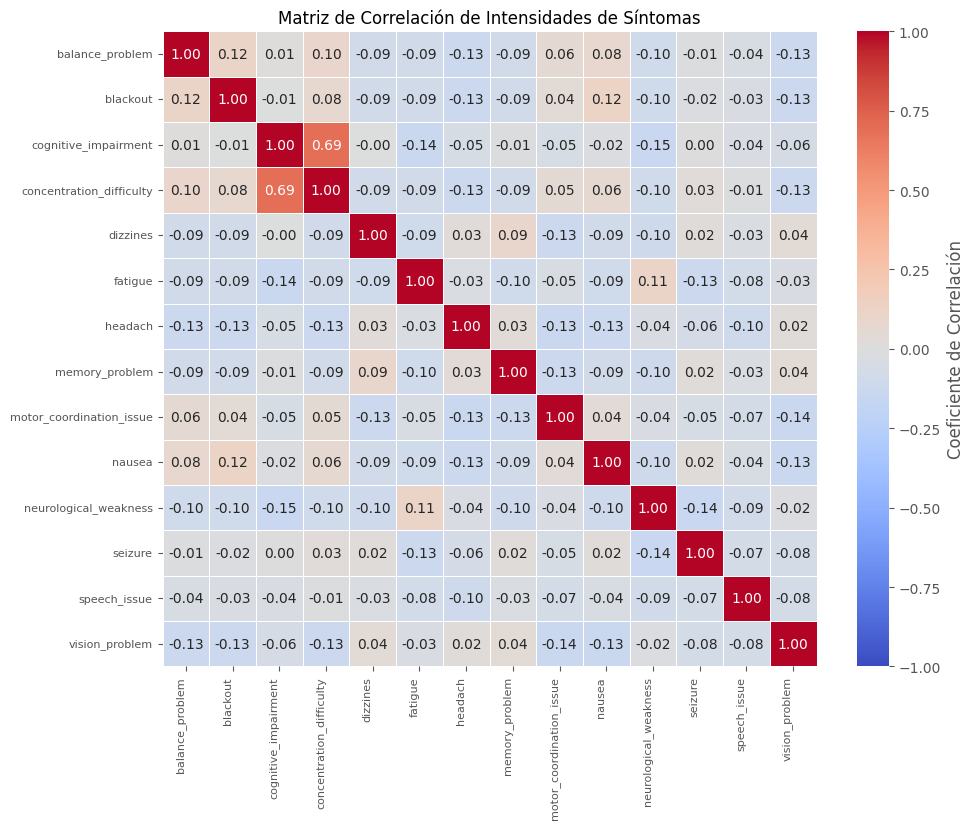


Matriz de Correlación (valores numéricos):



--- Matriz de Co-ocurrencia de Síntomas (Presencia/Ausencia) ---


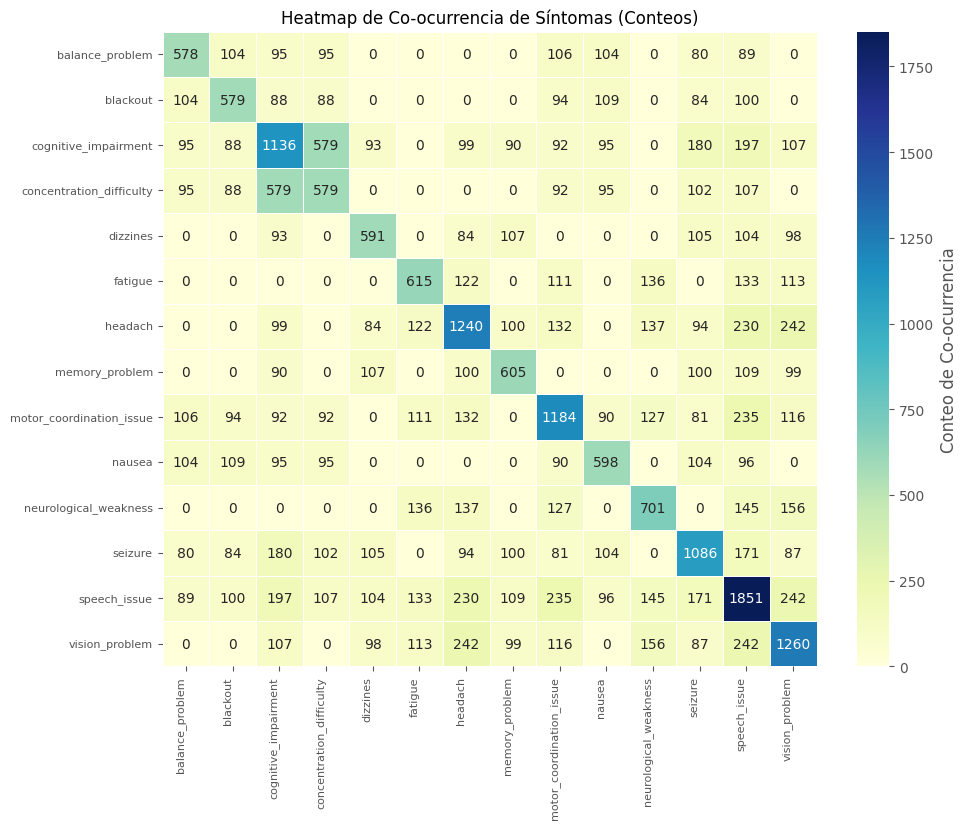


Tabla de Co-ocurrencia (Conteos):


balance_problem  blackout  cognitive_impairment  \
balance_problem                       578       104                    95   
blackout                              104       579                    88   
cognitive_impairment                   95        88                  1136   
concentration_difficulty               95        88                   579   
dizzines                                0         0                    93   
fatigue                                 0         0                     0   
headach                                 0         0                    99   
memory_problem                          0         0                    90   
motor_coordination_issue              106        94                    92   
nausea                                104       109                    95   
neurological_weakness                   0         0                     0   
seizure                                80        84                   180   
speech_issue                           89       100                   197   
vision_problem                          0         0                   107   

                          concentration_difficulty  dizzines  fatigue  \
balance_problem                                 95         0        0   
blackout                                        88         0        0   
cognitive_impairment                           579        93        0   
concentration_difficulty                       579         0        0   
dizzines                                         0       591        0   
fatigue                                          0         0      615   
headach                                          0        84      122   
memory_problem                                   0       107        0   
motor_coordination_issue                        92         0      111   
nausea                                          95         0        0   
neurological_weakness                            0         0      136   
seizure                                        102       105        0   
speech_issue                                   107       104      133   
vision_problem                                   0        98      113   

                          headach  memory_problem  motor_coordination_issue  \
balance_problem                 0               0                       106   
blackout                        0               0                        94   
cognitive_impairment           99              90                        92   
concentration_difficulty        0               0                        92   
dizzines                       84             107                         0   
fatigue                       122               0                       111   
headach                      1240             100                       132   
memory_problem                100             605                         0   
motor_coordination_issue      132               0                      1184   
nausea                          0               0                        90   
neurological_weakness         137               0                       127   
seizure                        94             100                        81   
speech_issue                  230             109                       235   
vision_problem                242              99                       116   

                          nausea  neurological_weakness  seizure  \
balance_problem              104                      0       80   
blackout                     109                      0       84   
cognitive_impairment          95                      0      180   
concentration_difficulty      95                      0      102   
dizzines                       0                      0      105   
fatigue                        0                    136        0   
headach                        0                    137       94   
memory_problem                 0            

In [51]:


if final_sym_cols:
    plot_symptom_correlation_matrix(clinical_df_final, final_sym_cols, annot=True, fmt=".2f") # fmt ajustado para dos decimales
    plot_symptom_cooccurrence_matrix(clinical_df_final, final_sym_cols, annot=True)
else:
    print("No hay columnas de síntomas finales para análisis de correlación o coocurrencia.")



**Insights Correlación de Intensidades:**

*   La correlación más destacada en la matriz es entre la intensidad de **`sym_cognitive_impairment` (deterioro cognitivo) y `sym_concentration_difficulty` (dificultad para concentrarse)**, con un coeficiente de **0.69**. Esta es una correlación positiva moderada-fuerte, lo que sugiere que estos dos síntomas tienden a variar juntos en intensidad, lo cual es coherente desde una perspectiva clínica.
*   Se observan algunas correlaciones positivas débiles, como entre `sym_blackout` (desmayos) y `sym_balance_problem` (problemas de equilibrio) (0.12), `sym_blackout` y `sym_nausea` (náuseas) (0.12), y `sym_fatigue` (fatiga) y `sym_neurological_weakness` (debilidad neurológica) (0.11). Estas podrían indicar asociaciones leves pero no determinantes.
*   También existen correlaciones negativas débiles, por ejemplo, entre `sym_cognitive_impairment` y `sym_neurological_weakness` (-0.15) o entre `sym_headach` (dolor de cabeza) y `sym_vision_problem` (problemas de visión) (-0.14). Estas son menos intuitivas y podrían requerir una exploración más profunda o ser simplemente ruido en los datos.
*   Sin embargo, **la gran mayoría de los pares de síntomas muestran coeficientes de correlación muy bajos (cercanos a cero)**. Esto indica que, en general, la intensidad de un síntoma no predice fuertemente la intensidad de la mayoría de los otros síntomas individuales, al menos no de forma lineal con la métrica de intensidad global utilizada.
*   Esto podría implicar que la escala de "intensidad global" extraída de las notas clínicas, aunque útil para capturar la severidad general, podría no capturar completamente las covariaciones más finas o las interdependencias complejas entre las intensidades de síntomas específicos. Alternativamente, las intensidades de muchos síntomas podrían ser manifestaciones relativamente independientes o su interrelación podría ser no lineal.

**Insights Coocurrencia de Síntomas (Presencia/Ausencia):**

*   La diagonal principal del heatmap confirma las frecuencias individuales de cada síntoma (ya analizadas previamente), siendo `speech_issue` el más común en general.
*   La co-ocurrencia más significativa, reflejando la correlación de intensidades, se da entre **`cognitive_impairment` y `concentration_difficulty`**, con **590 pacientes** reportando ambos síntomas. Esto refuerza la idea de una fuerte asociación sindrómica entre estas dos manifestaciones.
*   Se observan otras co-ocurrencias relevantes, aunque menos frecuentes, que podrían indicar patrones comunes de presentación:
    *   `speech_issue` (problemas del habla) tiende a co-ocurrir con `vision_problem` (242 casos), `headach` (230 casos), y `motor_coordination_issue` (problemas de coordinación motora) (237 casos).
    *   `headach` y `vision_problem` también muestran una co-ocurrencia notable (242 casos).
*   Síntomas como `cognitive_impairment` y `speech_issue` (199 casos), así como `cognitive_impairment` y `seizure` (convulsiones) (181 casos), también aparecen juntos con cierta frecuencia.
*   Por otro lado, existen numerosos pares de síntomas que rara vez o nunca co-ocurren en este conjunto de datos (valores de 0 o muy bajos en el heatmap). Por ejemplo, `neurological_weakness` no co-ocurre con varios de los síntomas más generales como `fatigue` o `dizzines` (mareos) en estos datos.
*   Estos patrones de co-ocurrencia pueden ayudar a identificar síndromes o conjuntos de síntomas característicos que podrían ser útiles para diferenciar entre condiciones o para entender mejor las manifestaciones clínicas de los tumores cerebrales. La presencia conjunta de ciertos síntomas podría tener un valor predictivo mayor que la suma de sus partes individuales.



#### 5.3.2. Perfil de Síntomas por `condition` (Tipo de Tumor)



--- Perfil de Síntomas por Condition ---


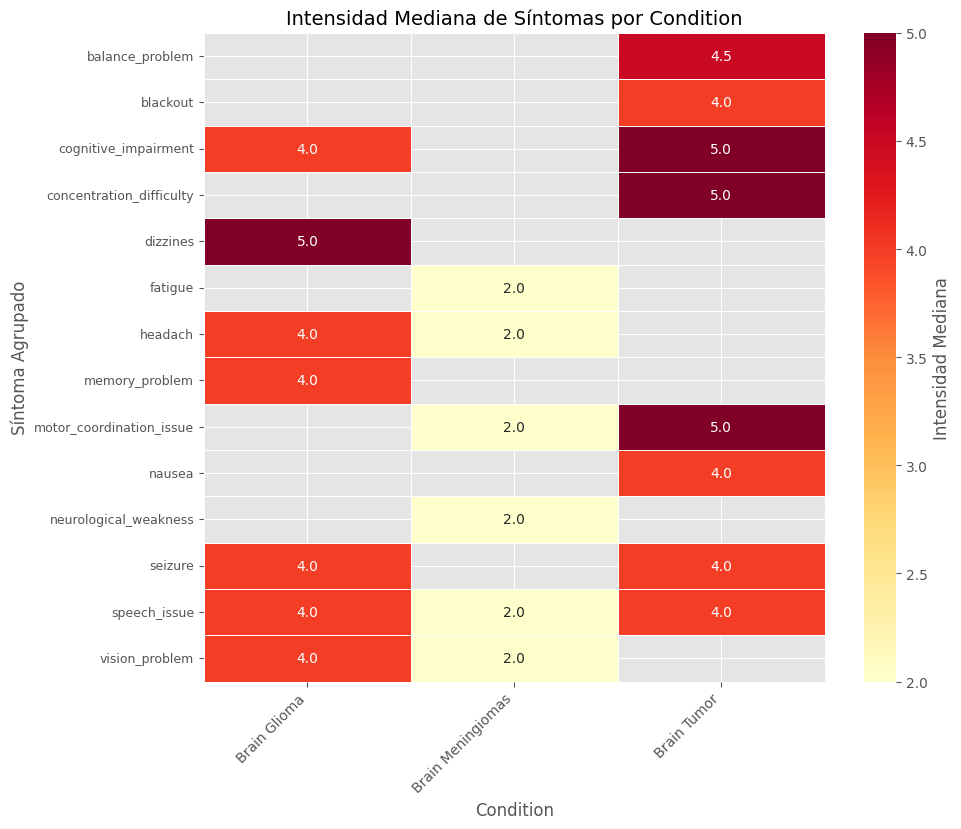

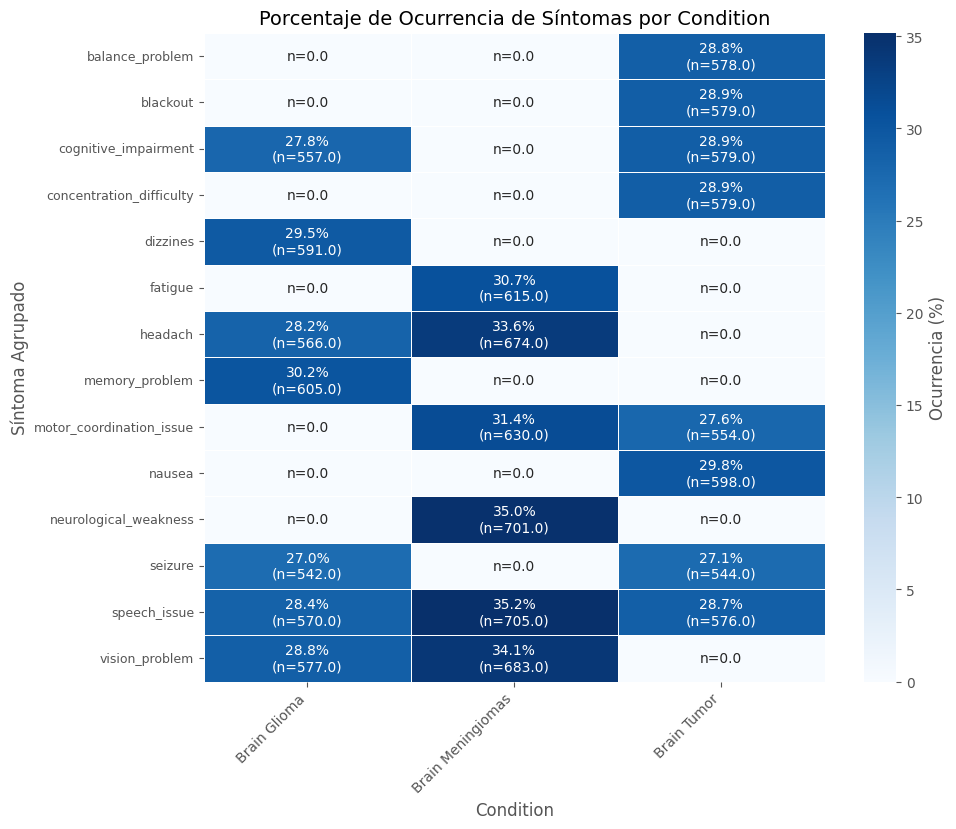


Tabla de Intensidad Mediana de Síntomas por Condition (NaN si no ocurre):


Brain Glioma  Brain Meningiomas  Brain Tumor
balance_problem                    NaN                NaN          4.5
blackout                           NaN                NaN          4.0
cognitive_impairment               4.0                NaN          5.0
concentration_difficulty           NaN                NaN          5.0
dizzines                           5.0                NaN          NaN
fatigue                            NaN                2.0          NaN
headach                            4.0                2.0          NaN
memory_problem                     4.0                NaN          NaN
motor_coordination_issue           NaN                2.0          5.0
nausea                             NaN                NaN          4.0
neurological_weakness              NaN                2.0          NaN
seizure                            4.0                NaN          4.0
speech_issue                       4.0                2.0          4.0
vision_problem                     4.0                2.0          NaN


Tabla de Porcentaje de Ocurrencia de Síntomas por Condition (%):


Brain Glioma  Brain Meningiomas  Brain Tumor
balance_problem                    0.0                0.0         28.8
blackout                           0.0                0.0         28.9
cognitive_impairment              27.8                0.0         28.9
concentration_difficulty           0.0                0.0         28.9
dizzines                          29.5                0.0          0.0
fatigue                            0.0               30.7          0.0
headach                           28.2               33.6          0.0
memory_problem                    30.2                0.0          0.0
motor_coordination_issue           0.0               31.4         27.6
nausea                             0.0                0.0         29.8
neurological_weakness              0.0               35.0          0.0
seizure                           27.0                0.0         27.1
speech_issue                      28.4               35.2         28.7
vision_problem                    28.8               34.1          0.0

In [52]:


if final_sym_cols and 'Condition' in clinical_df_final.columns:
    plot_symptom_profile_by_group(
        df=clinical_df_final,
        symptom_cols=final_sym_cols,
        group_by_col='Condition'
    )
else:
    print("No hay columnas de síntomas finales o 'condition' para el análisis de perfil de síntomas.")


**Insights Perfil de Síntomas por `condition`:**

Estos heatmaps revelan perfiles sintomáticos marcadamente distintos para cada tipo de tumor, tanto en términos de qué síntomas se presentan (ocurrencia) como en la intensidad mediana con la que lo hacen.

*   **Para `Brain Glioma`:**
    *   **Ocurrencia:** Los síntomas más característicos (con >25% de ocurrencia) son `dizzines` (mareos, 29.5%), `memory_problem` (problemas de memoria, 30.2%), `speech_issue` (problemas del habla, 28.4%), `vision_problem` (problemas de visión, 28.8%), `cognitive_impairment` (deterioro cognitivo, 27.8%), `headach` (dolor de cabeza, 28.2%), y `seizure` (convulsiones, 27.0%).
    *   **Intensidad Mediana:** Cuando estos síntomas se presentan, su intensidad mediana es generalmente moderada (4.0 en la escala definida), destacando `dizzines` con una intensidad de 5.0.
    *   **Ausencia Notoria:** Síntomas como `balance_problem` (problemas de equilibrio), `blackout` (desmayos/pérdida de conciencia), `concentration_difficulty` (dificultad para concentrarse), `fatigue` (fatiga), `motor_coordination_issue` (problemas de coordinación motora), `nausea` (náuseas), y `neurological_weakness` (debilidad neurológica) no se reportan (0.0% de ocurrencia) para los gliomas en este conjunto de datos.

*   **Para `Brain Meningiomas`:**
    *   **Ocurrencia:** Se caracterizan por la alta frecuencia de `neurological_weakness` (35.0%), `speech_issue` (35.2%), `vision_problem` (34.1%), `headach` (33.6%), `motor_coordination_issue` (31.4%), y `fatigue` (30.7%).
    *   **Intensidad Mediana:** A diferencia de los otros tipos de tumores, cuando estos síntomas ocurren en meningiomas, su intensidad mediana es consistentemente más baja (2.0 en la escala definida).
    *   **Ausencia Notoria:** Un conjunto diferente de síntomas está ausente (0.0% de ocurrencia), incluyendo `balance_problem`, `blackout`, `cognitive_impairment`, `concentration_difficulty`, `dizzines`, `memory_problem`, `nausea`, y `seizure`.

*   **Para `Brain Tumor` (categoría "Otros tumores"):**
    *   **Ocurrencia:** Muestra un perfil de síntomas activos diferente, con alta ocurrencia de `nausea` (30.1%), `balance_problem` (29.0%), `blackout` (28.8%), `cognitive_impairment` (28.8%), `concentration_difficulty` (28.8%), `speech_issue` (28.6%), `seizure` (27.2%), y `motor_coordination_issue` (27.5%).
    *   **Intensidad Mediana:** Los síntomas que se presentan tienden a tener una intensidad mediana de moderada a alta (4.0 a 5.0 en la escala definida), siendo `cognitive_impairment`, `concentration_difficulty`, y `motor_coordination_issue` los más intensos (mediana 5.0).
    *   **Ausencia Notoria:** Presenta ausencia de síntomas como `dizzines`, `fatigue`, `headach`, `memory_problem`, `neurological_weakness`, y `vision_problem`.

*   **Conclusión General:** Los perfiles de síntomas (tanto su presencia como su intensidad) varían significativamente entre los tipos de tumores. Esta diferenciación es muy importante para la tarea de clasificación y sugiere que las características de los síntomas serán muy valiosas para los modelos predictivos. La ausencia total de ciertos síntomas para tipos de tumores específicos es un fuerte indicador discriminativo y podría simplificar algunas reglas de decisión en los modelos.



#### 5.3.3. Perfil de Síntomas por `treatment` (Tipo de Tratamiento)



--- Perfil de Síntomas por Treatment ---


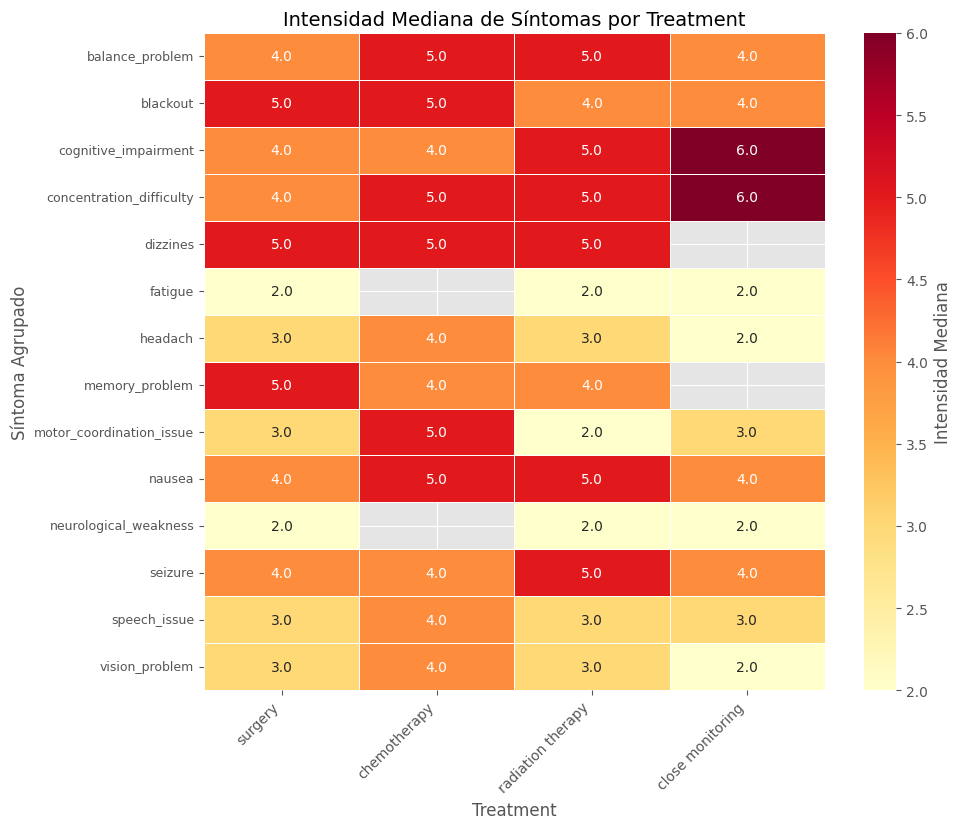

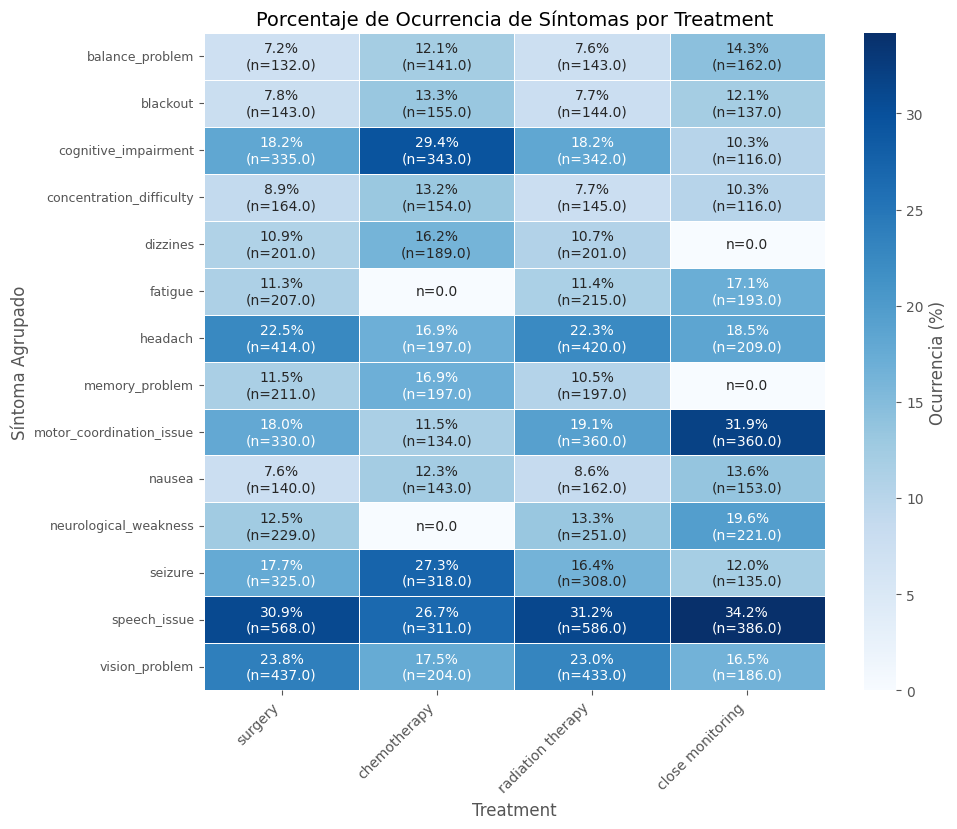


Tabla de Intensidad Mediana de Síntomas por Treatment (NaN si no ocurre):


surgery  chemotherapy  radiation therapy  \
balance_problem               4.0           5.0                5.0   
blackout                      5.0           5.0                4.0   
cognitive_impairment          4.0           4.0                5.0   
concentration_difficulty      4.0           5.0                5.0   
dizzines                      5.0           5.0                5.0   
fatigue                       2.0           NaN                2.0   
headach                       3.0           4.0                3.0   
memory_problem                5.0           4.0                4.0   
motor_coordination_issue      3.0           5.0                2.0   
nausea                        4.0           5.0                5.0   
neurological_weakness         2.0           NaN                2.0   
seizure                       4.0           4.0                5.0   
speech_issue                  3.0           4.0                3.0   
vision_problem                3.0           4.0                3.0   

                          close monitoring  
balance_problem                        4.0  
blackout                               4.0  
cognitive_impairment                   6.0  
concentration_difficulty               6.0  
dizzines                               NaN  
fatigue                                2.0  
headach                                2.0  
memory_problem                         NaN  
motor_coordination_issue               3.0  
nausea                                 4.0  
neurological_weakness                  2.0  
seizure                                4.0  
speech_issue                           3.0  
vision_problem                         2.0


Tabla de Porcentaje de Ocurrencia de Síntomas por Treatment (%):


surgery  chemotherapy  radiation therapy  \
balance_problem               7.2          12.1                7.6   
blackout                      7.8          13.3                7.7   
cognitive_impairment         18.2          29.4               18.2   
concentration_difficulty      8.9          13.2                7.7   
dizzines                     10.9          16.2               10.7   
fatigue                      11.3           0.0               11.4   
headach                      22.5          16.9               22.3   
memory_problem               11.5          16.9               10.5   
motor_coordination_issue     18.0          11.5               19.1   
nausea                        7.6          12.3                8.6   
neurological_weakness        12.5           0.0               13.3   
seizure                      17.7          27.3               16.4   
speech_issue                 30.9          26.7               31.2   
vision_problem               23.8          17.5               23.0   

                          close monitoring  
balance_problem                       14.3  
blackout                              12.1  
cognitive_impairment                  10.3  
concentration_difficulty              10.3  
dizzines                               0.0  
fatigue                               17.1  
headach                               18.5  
memory_problem                         0.0  
motor_coordination_issue              31.9  
nausea                                13.6  
neurological_weakness                 19.6  
seizure                               12.0  
speech_issue                          34.2  
vision_problem                        16.5

In [53]:


if final_sym_cols and 'Treatment' in clinical_df_final.columns:
    plot_symptom_profile_by_group(
        df=clinical_df_final,
        symptom_cols=final_sym_cols,
        group_by_col='Treatment'
    )
else:
    print("No hay columnas de síntomas finales o 'treatment' para el análisis de perfil de síntomas.")


**Observaciones Clave: Perfil de Síntomas por `treatment`**

El análisis de la ocurrencia e intensidad mediana de los síntomas agrupados, desglosado por tipo de tratamiento, revela patrones interesantes que podrían estar influenciados tanto por la sintomatología que lleva a la elección de un tratamiento como por el tipo de tumor subyacente (dada la fuerte relación entre `condition` y `treatment`).

**Intensidad Mediana de Síntomas por Tratamiento:**
*   **Cirugía (Surgery):** Presenta una intensidad mediana generalmente moderada (3.0-5.0) para los síntomas que ocurren. `dizzines` y `memory_problem` muestran una mediana de 5.0.
*   **Quimioterapia (Chemotherapy):** Muestra intensidades medianas consistentemente altas (4.0-5.0) para la mayoría de los síntomas cuando están presentes. Esto podría indicar que la quimioterapia se considera para casos con sintomatología más severa o que los síntomas asociados a tumores que reciben quimio son inherentemente más intensos. `fatigue` tiene una intensidad mediana más baja (2.0).
*   **Radioterapia (Radiation Therapy):** Las intensidades medianas son variables, con algunos síntomas mostrando una intensidad alta (5.0 para `balance_problem`, `blackout`, `cognitive_impairment`, `concentration_difficulty`, `dizzines`, `nausea`) y otros más moderada (2.0-3.0 para `fatigue`, `headach`, `motor_coordination_issue`).
*   **Seguimiento Cercano (Close Monitoring):** Tiende a mostrar intensidades medianas altas (4.0-6.0) para los síntomas que se presentan, destacando `concentration_difficulty` con una mediana de 6.0. Sin embargo, algunos síntomas como `dizzines` y `memory_problem` no se registran (`Missing value`) en este grupo, indicando que no ocurren o son extremadamente raros en pacientes bajo seguimiento cercano.

**Porcentaje de Ocurrencia de Síntomas por Tratamiento:**
*   **Cirugía (Surgery):**
    *   Los síntomas más frecuentes son `headach` (22.5%), `cognitive_impairment` (18.2%), y `motor_coordination_issue` (18.0%).
*   **Quimioterapia (Chemotherapy):**
    *   Se destaca la alta ocurrencia de `cognitive_impairment` (29.4%). Otros síntomas comunes incluyen `dizzines` (16.2%), `memory_problem` (16.9%), `balance_problem` (12.1%), y `nausea` (12.3%).
    *   Notablemente, `fatigue` tiene un 0.0% de ocurrencia en pacientes que reciben quimioterapia en este dataset, lo cual es un hallazgo particular.
*   **Radioterapia (Radiation Therapy):**
    *   `headach` (22.3%) y `cognitive_impairment` (18.2%) son los más comunes.
*   **Seguimiento Cercano (Close Monitoring):**
    *   Este grupo presenta un perfil de ocurrencia distintivo. `motor_coordination_issue` es el más frecuente (31.9%), seguido por `headach` (18.5%) y `fatigue` (17.1%).
    *   Es llamativo que `dizzines` y `memory_problem` tengan un 0.0% de ocurrencia en este grupo, lo que sugiere que los pacientes con estos síntomas podrían no ser candidatos primarios para "seguimiento cercano" o que estos síntomas no son característicos de las condiciones bajo este manejo.

**Conclusiones e Implicaciones:**
*   **Perfiles Sintomáticos Diferenciados:** Existen diferencias en los perfiles de síntomas asociados con cada tipo de tratamiento. Por ejemplo, la alta ocurrencia de `cognitive_impairment` en pacientes con quimioterapia, o la alta frecuencia de `motor_coordination_issue` en aquellos bajo seguimiento cercano.
*   **Interacción con Tipo de Tumor:** Es crucial recordar que la elección del tratamiento está fuertemente ligada al tipo de tumor (`condition`). Por lo tanto, los perfiles sintomáticos observados por tratamiento probablemente reflejan en gran medida los síntomas característicos de los tipos de tumores que suelen recibir dichos tratamientos. Por ejemplo, si los gliomas (que no reciben `close monitoring`) son los que más presentan `dizzines`, esto explicaría su ausencia en el grupo de `close monitoring`.
*   **Potencial para Modelado:** Estas diferencias, aunque interrelacionadas con el tipo de tumor, podrían aportar información adicional al modelo de recomendación de tratamiento, ayudando a refinar las predicciones basadas en la presentación sintomática del paciente.
*   **Ausencias Notables:** La ausencia total (0.0% de ocurrencia) de ciertos síntomas en algunos grupos de tratamiento (ej. `fatigue` en quimioterapia, `dizzines` y `memory_problem` en seguimiento cercano) son hallazgos fuertes que merecen consideración, aunque siempre contrastándolos con el conocimiento clínico y la posibilidad de que sean artefactos del tamaño muestral o características específicas de este dataset sintético.

---
#### Conclusiones Importantes  Generales del EDA para la Predicción del Tratamiento

Tras un análisis exhaustivo de los datos clínicos, se han identificado varios factores con un potencial significativo para predecir el tratamiento más adecuado para un paciente. Estos hallazgos orientarán la selección de características y la estrategia de modelado:

1.  **El Tipo de Tumor (`condition`) es el Predictor Dominante:** Existe una fuerte y clara asociación entre el tipo de tumor diagnosticado y el tratamiento subsecuente. Los perfiles de tratamiento varían drásticamente:
    *   Los **Gliomas** se tratan principalmente con una combinación de quimioterapia, radioterapia y cirugía, excluyendo el seguimiento cercano.
    *   Los **Meningiomas** se manejan con radioterapia, cirugía o seguimiento cercano, con una notable ausencia de quimioterapia.
    *   La categoría **"Otros Tumores" (`Brain Tumor`)** muestra una distribución más equitativa entre los cuatro tipos de tratamiento.
    Esta variable será fundamental en el modelo de recomendación de tratamiento.

2.  **Los Perfiles Sintomáticos son Altamente Discriminativos:**
    *   **Por Tipo de Tumor:** Cada tipo de tumor presenta un conjunto característico de síntomas en términos de su ocurrencia e intensidad. Por ejemplo, la ausencia total de ciertos síntomas en algunos tipos de tumores (como la falta de `fatigue` en gliomas o `dizzines` en meningiomas) es un fuerte indicador.
    *   **Por Tipo de Tratamiento:** También se observan diferencias en los perfiles de síntomas de los pacientes según el tratamiento recibido. Por ejemplo, la alta ocurrencia de `cognitive_impairment` en pacientes que reciben quimioterapia, o la prevalencia de `motor_coordination_issue` en aquellos bajo seguimiento cercano.
    *   Estas características sintomáticas (presencia/ausencia e intensidad) serán cruciales para predecir tanto el tipo de tumor como, subsecuentemente o directamente, el tratamiento.

3.  **La Duración de los Síntomas (`duration_days`) Aporta Información Valiosa:**
    *   Se observan diferencias significativas en la duración de los síntomas entre los tipos de tumores (meningiomas con menor duración, "otros tumores" con la mayor).
    *   Además, la duración de los síntomas también se relaciona con el tratamiento recibido, con medianas de duración más bajas para cirugía y radioterapia en comparación con la quimioterapia. Esto sugiere que la cronicidad de los síntomas influye en la decisión terapéutica.

4.  **Edad y Sexo con Influencia Limitada (Directa):**
    *   Ni la edad ni el sexo de los pacientes parecen ser factores fuertemente diferenciadores ni para el tipo de tumor ni para el tipo de tratamiento de forma aislada en este conjunto de datos. Sus distribuciones son bastante homogéneas entre las diferentes categorías.
    *   Si bien podrían tener un rol en interacciones más complejas o en modelos no lineales, su impacto directo parece secundario en comparación con el tipo de tumor y la sintomatología.

5.  **Interrelación de Factores:** Es evidente que muchos de estos factores están interrelacionados. Por ejemplo, un perfil sintomático específico puede ser característico de un tipo de tumor, el cual a su vez se asocia con un conjunto particular de tratamientos. El modelo deberá ser capaz de capturar estas dependencias.

---



##  6. Exploración Inicial de Datos de Imágenes
#
 Realizamos una carga y visualización básica de las imágenes MRI para familiarizarnos con este tipo de datos.


In [ ]:

# --- Cargar rutas de imágenes usando la función de utilidad y config ---
glioma_image_paths = get_image_paths(config.GLIOMA_IMAGE_PATH, config.IMAGE_EXTENSIONS)
menin_image_paths = get_image_paths(config.MENIN_IMAGE_PATH, config.IMAGE_EXTENSIONS)
tumor_image_paths = get_image_paths(config.TUMOR_IMAGE_PATH, config.IMAGE_EXTENSIONS) # "Otros tumores"

print(f"Número de imágenes de Glioma: {len(glioma_image_paths)}")
print(f"Número de imágenes de Meningioma: {len(menin_image_paths)}")
print(f"Número de imágenes de Otros Tumores: {len(tumor_image_paths)}")

print("\nEjemplo de rutas de Glioma:")
for p in glioma_image_paths[:3]: print(p)


Número de imágenes de Glioma: 2004
Número de imágenes de Meningioma: 2004
Número de imágenes de Otros Tumores: 2048

Ejemplo de rutas de Glioma:
C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0001.jpg
C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0002.jpg
C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0003.jpg




#### Visualización de Muestras de Imágenes MRI



--- Muestras de Imágenes de Glioma ---


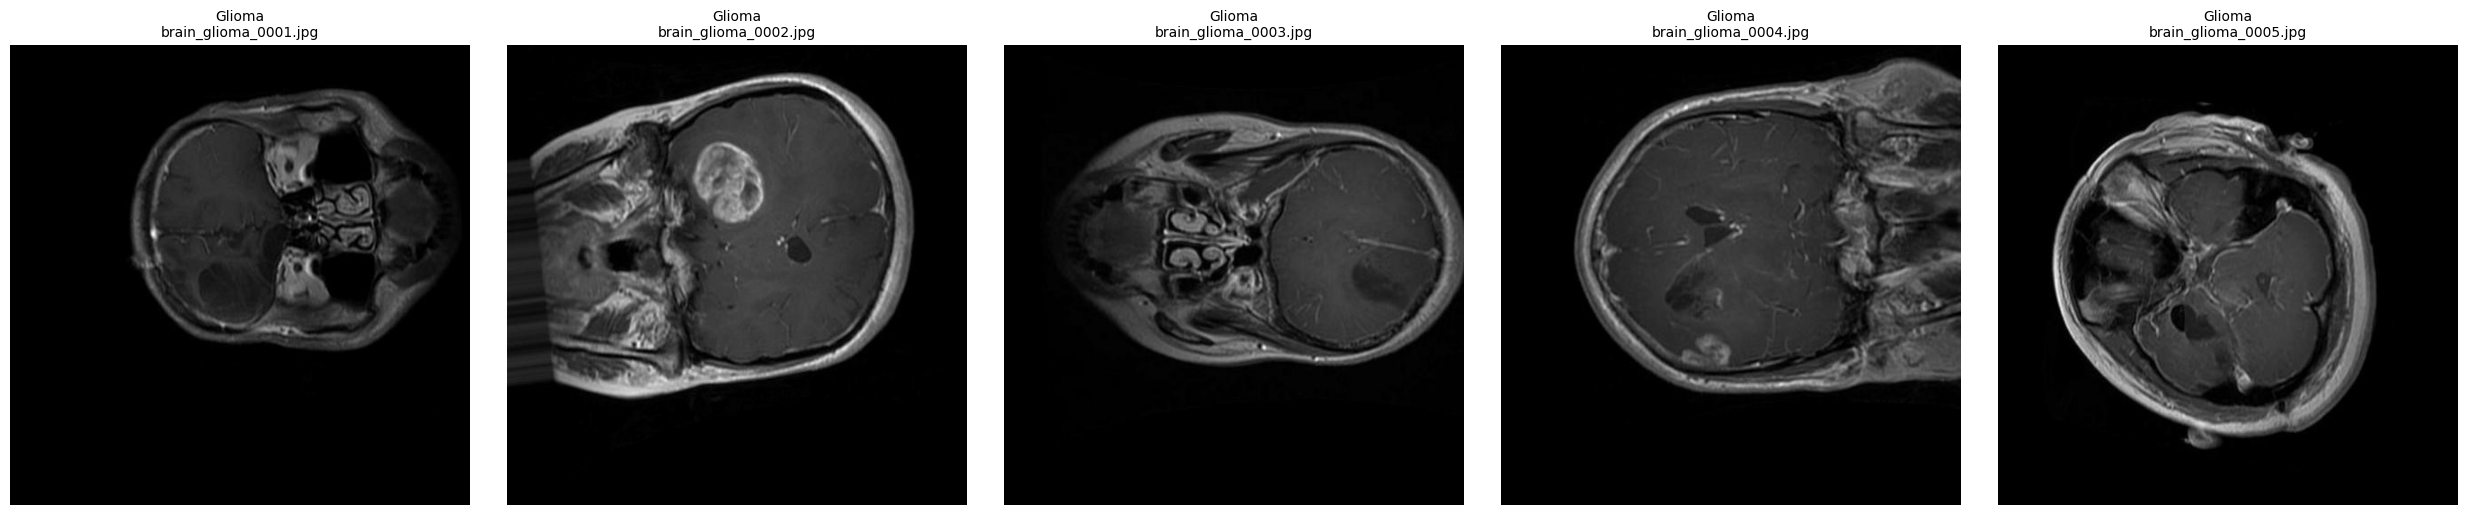


--- Muestras de Imágenes de Meningioma ---


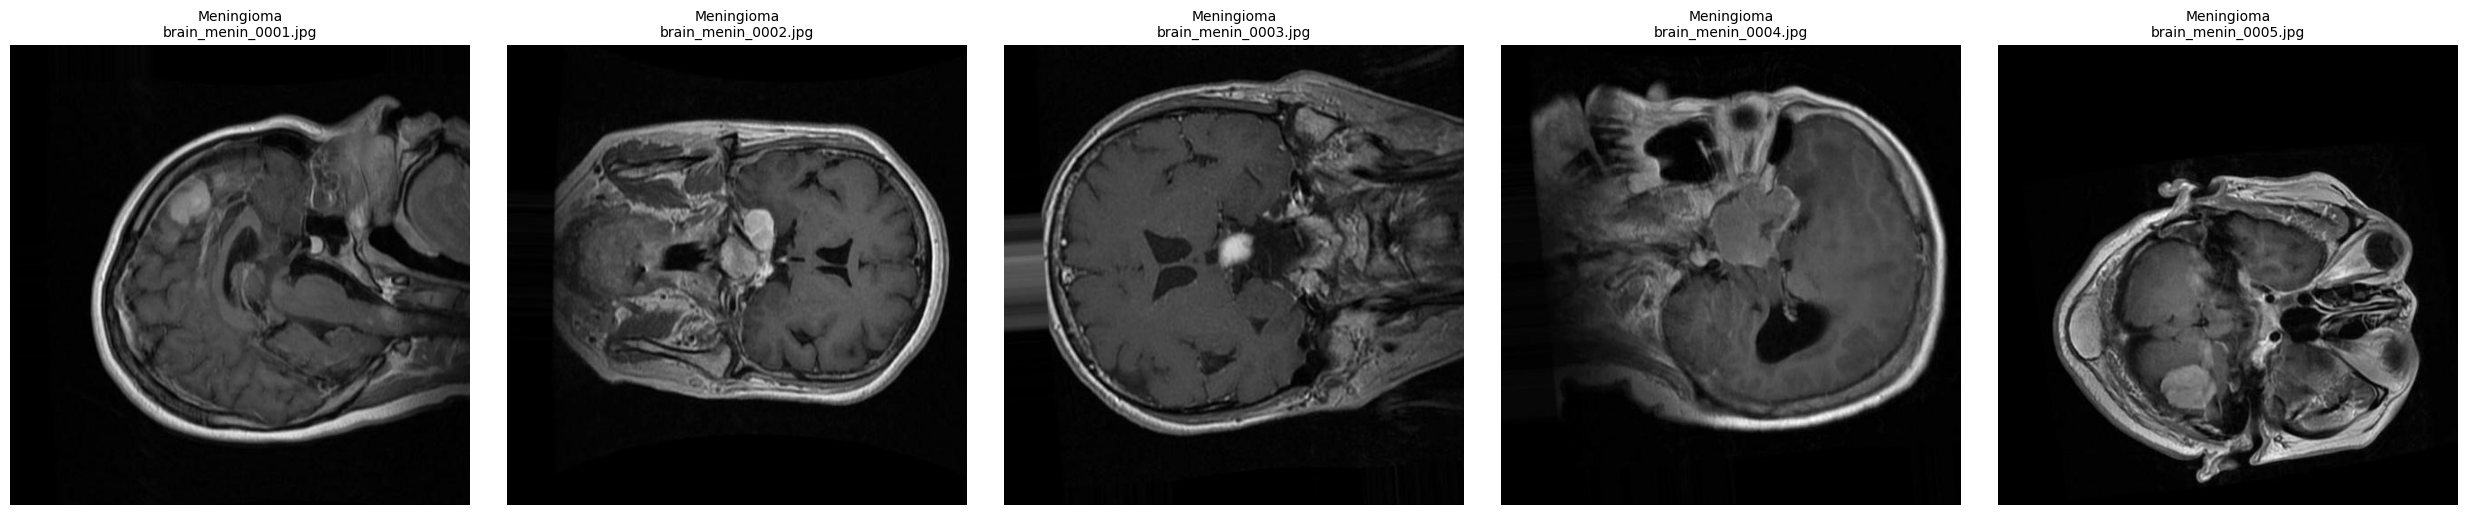


--- Muestras de Imágenes de Otros Tumores ---


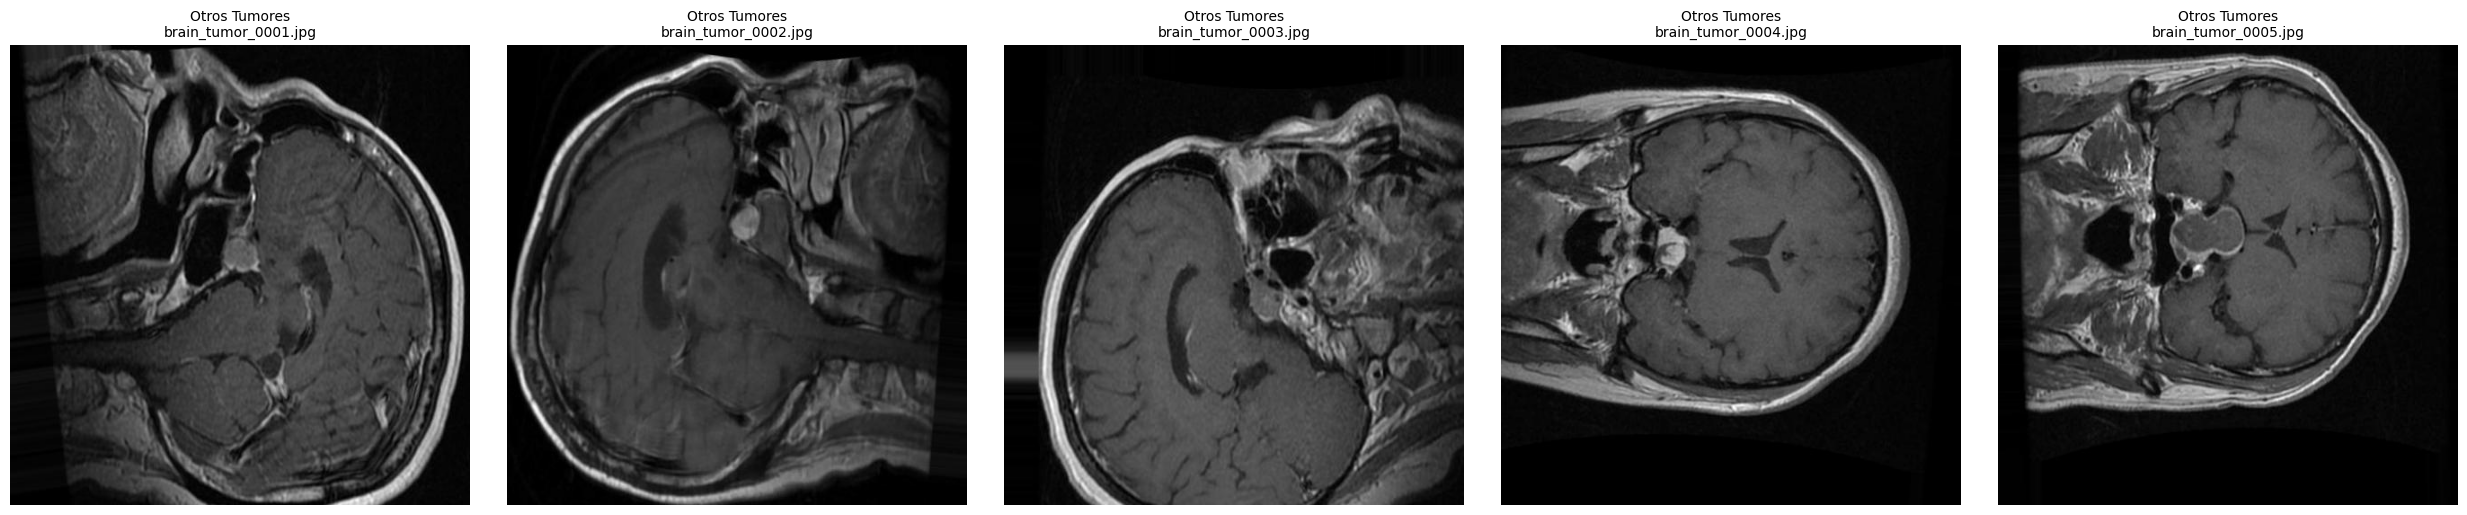

In [55]:


# --- Visualizar algunas imágenes de muestra ---
def display_sample_images(image_paths: list, n_samples: int = 5, title_prefix: str = ""):
    if not image_paths:
        print(f"No hay imágenes para mostrar para {title_prefix}")
        return

    fig, axes = plt.subplots(1, n_samples, figsize=(5 * n_samples, 5))
    if n_samples == 1: # Si solo hay una muestra, axes no es un array
        axes = [axes]

    for i, img_path in enumerate(image_paths[:n_samples]):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{title_prefix}\n{img_path.name}", fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error cargando {img_path}: {e}")
            if n_samples > 1 : axes[i].axis('off') # Asegurar que el eje se apaga incluso con error si hay múltiples subplots
    plt.tight_layout()
    plt.show()

print("\n--- Muestras de Imágenes de Glioma ---")
display_sample_images(glioma_image_paths, title_prefix="Glioma")

print("\n--- Muestras de Imágenes de Meningioma ---")
display_sample_images(menin_image_paths, title_prefix="Meningioma")

print("\n--- Muestras de Imágenes de Otros Tumores ---")
display_sample_images(tumor_image_paths, title_prefix="Otros Tumores")


**Insights (Inspeccion Visual) relevantes:**

* Las imágenes llegan ya preprocesadas con resolución 512×512 px y contraste de intensidad homogéneo, lo que elimina la necesidad de normalización adicional.
* Cada imagen aparenta haber sido rotada in-plane para alinear un eje principal en horizontal y centrarlo en el lienzo, reflejo de un tratamiento de PDI más allá de la simple orientación anatómica.
* La presencia de bordes blancos simétricos y ligeras distorsiones sugiere remuestreos o recortes durante el ajuste al cuadro de 512×512. (Aunque la documentacion solo reporta el img rezize 512x512 )
* Respecto a la información diagnóstica:

  * En los gliomas aparecen claramente masas hiperdensas e irregulares, aunque no en todos los cortes.
  * En los meningiomas se observan realces definidos en la meninge y en algunos abultamintos perimetrales, aunque no en todos los cortes.
  * En la categoría “Otros tumores” algunos slices muestran realces muy sutiles, e incluso ninguno, lo que podría indicar que no todos aportan señal patológica.

**Reflexiones:**

* Estandarizar orientación y tamaño agiliza el entrenamiento, pero los remuestreos no documentados pueden convertirse en artefactos espurios que el modelo aprenda en lugar de rasgos clínicos.
* La variabilidad en la visibilidad de la lesión refuerza la duda de si todos los cortes son útiles; algunos podrían carecer por completo de información tumor-específica.
* Para la implementación en producción será clave replicar exactamente las rotaciones, el padding y las interpolaciones usadas, evitando así sesgos por diferencias de procesamiento.
* En un escenario real resulta imprescindible colaborar con expertos clínicos para validar cada slice, decidir si conviene filtrar imágenes sin patología y asegurar que el dataset refleje únicamente características relevantes.





##  7. Guardado de Datos Procesados
#
 Finalmente, guardamos el DataFrame clínico procesado (`clinical_df_final`) en un archivo CSV. Este archivo servirá como entrada para los siguientes notebooks del pipeline, donde se desarrollarán los modelos de machine learning.


In [ ]:
# -- Definir mapeo de carpetas de imágenes (desde config.py) ---
image_folders_config_map = {
    "brain_glioma": config.GLIOMA_IMAGE_PATH,
    "brain_menin": config.MENIN_IMAGE_PATH,
    "brain_tumor": config.TUMOR_IMAGE_PATH
}

# -- Construir mapeo de Case ID a ruta de imagen ---
case_id_to_image_path_dict = build_case_id_to_image_map(
    image_folders_map=image_folders_config_map,
    image_extensions=config.IMAGE_EXTENSIONS, # De config.py
    get_image_paths_func=get_image_paths     # De src.utils
)

# -- Estandarizar nombres de columnas y preparar para mapeo ---
df_to_process = clinical_df_final.copy()
df_to_process = standardize_column_names(df_to_process) # Asegura columna 'case_id'

# --- 4. Mapear rutas de imágenes al DataFrame ---
df_to_process['image_path'] = df_to_process['case_id'].map(case_id_to_image_path_dict)

# Verificación del mapeo
num_mapped_paths = df_to_process['image_path'].notna().sum()
num_missing_paths = df_to_process['image_path'].isna().sum()
print(f"Filas con ruta de imagen mapeada: {num_mapped_paths}")
if num_missing_paths > 0:
    missing_case_ids = df_to_process[df_to_process['image_path'].isna()]['case_id'].unique()
    print(f"ADVERTENCIA: {num_missing_paths} filas sin ruta de imagen mapeada.")
    if len(missing_case_ids) > 0:
        print(f"  IDs faltantes (ejemplos): {missing_case_ids[:10]}")

# -- Reordenar columnas ---
df_processed_reordered = reorder_dataframe_columns(
    df_to_process.copy(),
    id_col_name='case_id',
    target_col_names=['condition', 'treatment'],
    symptom_prefix='sym_',
    clinical_note_col_name='clinical_note'
)

# -- Guardar DataFrame procesado ---
save_processed_dataframe(
    df=df_processed_reordered,
    output_dir=config.BASE_PROJECT_PATH / "data" / "processed",
    filename="clinical_data_processed_with_paths.csv"
)

# --- Actualizar DataFrame principal ---
clinical_df_final = df_processed_reordered
print("\nEnriquecimiento y guardado completado.")


--- Construyendo mapeo de Case ID a rutas de imágenes ---
Total de archivos de imagen escaneados: 6056
Imágenes omitidas por contener 'copy' en el nombre: 44
Número de Case IDs únicos con una ruta de imagen asignada: 6012

--- Renombrando columnas para estandarización ---
Columnas renombradas.
Filas con ruta de imagen mapeada: 6012

--- Reordenando columnas ---
Columnas reordenadas. Nuevo orden: ['case_id', 'age', 'duration_days', 'image_path', 'sex', 'sym_balance_problem', 'sym_blackout', 'sym_cognitive_impairment', 'sym_concentration_difficulty', 'sym_dizzines', 'sym_fatigue', 'sym_headach', 'sym_memory_problem', 'sym_motor_coordination_issue', 'sym_nausea', 'sym_neurological_weakness', 'sym_seizure', 'sym_speech_issue', 'sym_vision_problem', 'clinical_note', 'condition', 'treatment']

--- Guardando DataFrame procesado ---

DataFrame procesado guardado en: C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\processed\clinical_data_processed_with_paths.

case_id  age  duration_days  \
0  brain_glioma_0001   74             21   
1  brain_glioma_0002   66             60   
2  brain_glioma_0003   62            210   
3  brain_glioma_0004   24            210   
4  brain_glioma_0005   69             60   

                                                                                                                                                         image_path  \
0  C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0001.jpg   
1  C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0002.jpg   
2  C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0003.jpg   
3  C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0004.jpg   
4  C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\data\Brain_Cancer raw MRI data\brain_cancer_IMG\brain_glioma\brain_glioma_0005.jpg   

  sex  sym_balance_problem  sym_blackout  sym_cognitive_impairment  \
0   F                  0.0           0.0                       0.0   
1   F                  0.0           0.0                       3.0   
2   F                  0.0           0.0                       0.0   
3   M                  0.0           0.0                       0.0   
4   M                  0.0           0.0                       0.0   

   sym_concentration_difficulty  sym_dizzines  sym_fatigue  sym_headach  \
0                           0.0           0.0          0.0          0.0   
1                           0.0           0.0          0.0          0.0   
2                           0.0           5.0          0.0          0.0   
3                           0.0           0.0          0.0          8.0   
4                           0.0           8.0          0.0          0.0   

   sym_memory_problem  sym_motor_coordination_issue  sym_nausea  \
0                 5.0                           0.0         0.0   
1                 0.0                           0.0         0.0   
2                 5.0                           0.0         0.0   
3                 8.0                           0.0         0.0   
4                 0.0                           0.0         0.0   

   sym_neurological_weakness  sym_seizure  sym_speech_issue  \
0                        0.0          0.0               5.0   
1                        0.0          0.0               0.0   
2                        0.0          0.0               0.0   
3                        0.0          0.0               0.0   
4                        0.0          8.0               0.0   

   sym_vision_problem  \
0                 0.0   
1                 3.0   
2                 0.0   
3                 0.0   
4                 0.0   

                                                                                                                                clinical_note  \
0      Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.   
1         Patient is experiencing visual disturbances and confusion over the past 2 months. The symptoms are described as moderate in nature.   
2                Patient is experiencing memory lapses and dizziness for more than 6 months. The symptoms are described as intense in nature.   
3  Patient is experiencing memory lapses and persistent headaches for more than 6 months. The symptoms are described as high-grade in nature.   
4         Patient is experiencing dizziness and frequent seizures over the past 2 months. The symptoms are described as high-grade in nature.   

      condition     treatment  
0  Brain Glioma       surgery  
1  Br


Enriquecimiento y guardado completado.



 ---

**Fin del Notebook 01: EDA y Preprocesamiento.**
El siguiente paso es utilizar `clinical_data_processed_features.csv` y los datos de imágenes para entrenar el modelo de clasificación de tumores.
 
 ---